# Libraries

In [1]:
import collections
import copy
import itertools
import json
import logging
# Imports and setup
import os
from collections import defaultdict
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import to_dense_adj, k_hop_subgraph
from tqdm.notebook import tqdm

In [2]:
import warnings
from Bio.PDB.PDBExceptions import PDBConstructionWarning

# Suppress PDB warnings globally
warnings.simplefilter('ignore', PDBConstructionWarning)

from preprocessing_v3 import ProteinAnalyzer, process_pdb_directory
#from utils_ln import load_aa_info  # Or define `load_aa_info` in the same script

# Configuration

In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set environment variable for MPS fallback
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Set plot style
sns.set_theme()

# Device setup
def get_device():
    """Get the best available device with fallbacks"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        logger.info("MPS (M1/M2) device found but using CPU for some operations due to compatibility")
        return torch.device('cpu')
    return torch.device('cpu')

def compute_average_edges(data_loader):
    """
    Compute the average number of edges and nodes in the dataset
    """
    total_edges = 0
    total_nodes = 0
    num_graphs = 0

    for batch in data_loader:
        total_edges += batch.edge_index.size(1) // 2  # Divide by 2 for undirected edges
        total_nodes += batch.x.size(0)
        num_graphs += 1

    return {
        'avg_edges': total_edges / num_graphs,
        'avg_nodes': total_nodes / num_graphs,
        'avg_backbone': total_nodes / num_graphs - 1  # One less than nodes
    }

# Paths and constants

In [4]:
# Define the file for a demo protein structure
pdb_file = 'data/all_nano_structures_single_domain/1zv5.pdb'

# Define the directory containing the PDB files
pdb_directory = 'data/all_nano_structures_single_domain'

# Define the file containing amino acid information
aa_info_file = 'aa_mass_letter.csv'

# Preprocessed protein dataframes 
output_dir = "processed_dataframes"

# Preprocessing

In [5]:
# Load amino acid information
aa_info = pd.read_csv(aa_info_file)
aa_info['Abbrev.'] = aa_info['Abbrev.'].apply(lambda x: x.upper())
aa_info_dict = aa_info.set_index('Abbrev.').to_dict(orient='index')
#aa_info_dict

In [6]:
# Process PDB directory
dataframes = process_pdb_directory(pdb_directory, aa_info_dict, neighborhood_radius=5.0)


Processing PDBs: 100%|██████████| 1636/1636 [08:46<00:00,  3.11it/s]


In [7]:
dataframes[30]

('data/all_nano_structures_single_domain/6rbb.pdb',
              X          Y       Z   Avg_Mass  Avg_Neighbor_Dist  \
 0     0.694000  -4.277000   5.308  174.20274           3.721274   
 1    -2.990000  -4.576000   5.740   75.06714           4.198928   
 2    -6.508000  -3.784000   4.701  105.09344           3.805953   
 3    -8.875000  -3.795000   7.749  147.13074           3.833386   
 4    -6.175000  -5.348000   9.939  165.19184           3.788165   
 ..         ...        ...     ...        ...                ...   
 478 -33.832001 -20.900999  10.996  117.14784           4.169421   
 479 -33.150002 -18.483999   8.138  119.12034           4.082392   
 480 -34.498001 -14.935000   8.444  117.14784           4.093996   
 481 -34.692001 -12.858000   5.268  105.09344           4.145524   
 482 -34.766998  -9.058000   5.304  105.09344           3.800911   
 
      Max_Neighbor_Dist  Neighbor_Count  Small_Molecules_Found  
 0             3.721274               1                      1  


In [8]:
import os

# Directory to store processed DataFrames
os.makedirs(output_dir, exist_ok=True)

# Save each DataFrame to a pickle file
for pdb_file, df in dataframes:
    pdb_id = os.path.basename(pdb_file).replace('.pdb', '')  # Extract PDB ID from filename
    df.to_pickle(os.path.join(output_dir, f"{pdb_id}.pkl"))

print(f"DataFrames saved in {output_dir} as pickle files")


DataFrames saved in processed_dataframes as pickle files


# Graph conversion

In [9]:
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors

def nanobody_to_graph(df, k=10, include_coordinates=True):
    """
    Convert a nanobody DataFrame into a graph for GTA-based GNNs.

    Parameters:
    - df: DataFrame containing nanobody data.
    - k: Number of nearest neighbors for graph connectivity.
    - include_coordinates: Whether to include 3D coordinates in node features.

    Returns:
    - PyTorch Geometric Data object.
    """
    # Step 1: Node Features
    features_to_include = ['Avg_Mass', 'Avg_Neighbor_Dist', 'Max_Neighbor_Dist', 'Neighbor_Count', 'Small_Molecules_Found']
    node_features = df[features_to_include].values

    # Optionally include coordinates in node features
    if include_coordinates:
        coords = df[['X', 'Y', 'Z']].values
        node_features = np.hstack([node_features, coords])

    # Convert to tensor
    node_features = torch.tensor(node_features, dtype=torch.float)

    # Step 2: KNN-based Edge Construction
    coords = df[['X', 'Y', 'Z']].values
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)

    edge_index = []
    edge_attr = []
    for i in range(len(indices)):
        for j in range(1, k):  # Skip self-loop (j=0)
            edge_index.append([i, indices[i, j]])
            edge_attr.append([distances[i, j]])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Step 3: Create Graph Data Object
    data = Data(
        x=node_features,      # Node features
        edge_index=edge_index,  # Edges
        edge_attr=edge_attr,   # Edge features (distances)
    )
    return data


In [10]:
graphs = []  # Define `graphs` outside the loop
for pdb_file, df in tqdm(dataframes, desc="Processing", unit="graph", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"):
    graph = nanobody_to_graph(df, k=5, include_coordinates=True)
    graphs.append((pdb_file, graph))


Processing:   0%|          | 0/1636 [00:00<?]

# Graph representation vs reality

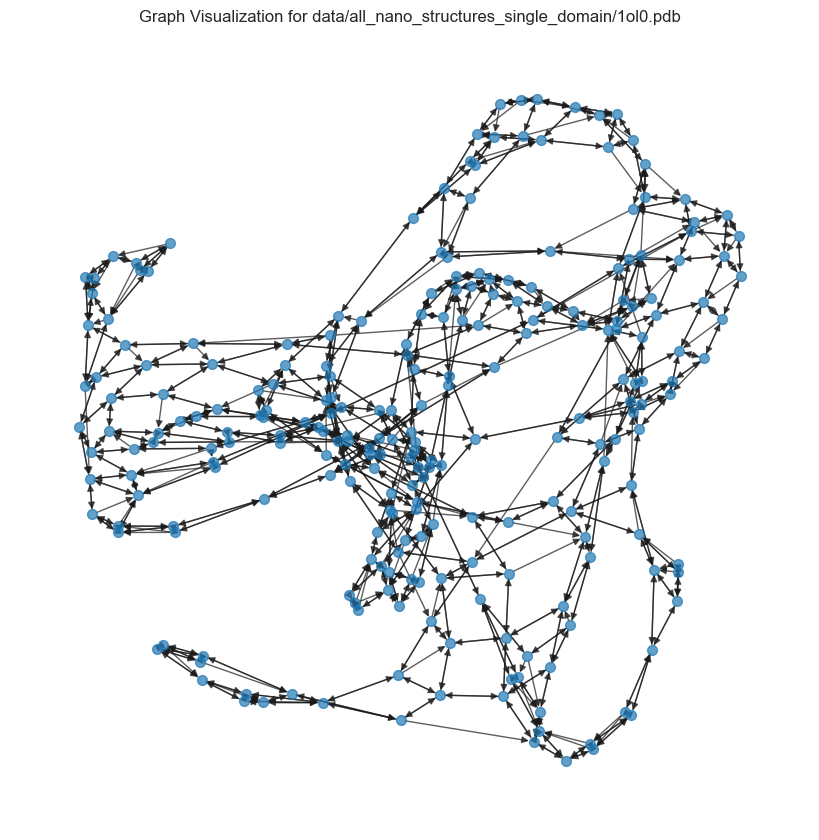

In [11]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

def visualize_nanobody_graph(data, pdb_file):
    """Visualize the nanobody graph."""
    G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=False, node_size=50, alpha=0.7)
    plt.title(f"Graph Visualization for {pdb_file}")
    plt.show()

# Example
pdb_file, data = graphs[10]
visualize_nanobody_graph(data, pdb_file)


In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Define amino acid masses and their corresponding colors
AMINO_ACID_DATA = [
    (89.09404, "Alanine", "blue"),
    (121.15404, "Cysteine", "green"),
    (133.10384, "Aspartic acid", "red"),
    (147.13074, "Glutamic acid", "cyan"),
    (165.19184, "Phenylalanine", "magenta"),
    (75.06714, "Glycine", "yellow"),
    (155.15634, "Histidine", "orange"),
    (131.17464, "Isoleucine/Leucine", "purple"),
    (146.18934, "Lysine", "brown"),
    (149.20784, "Methionine", "pink"),
    (132.11904, "Asparagine", "lime"),
    (255.31000, "Pyrrolysine", "gold"),
    (115.13194, "Proline", "silver"),
    (146.14594, "Glutamine", "teal"),
    (174.20274, "Arginine", "coral"),
    (105.09344, "Serine", "navy"),
    (119.12034, "Threonine", "olive"),
    (168.05300, "Selenocysteine", "maroon"),
    (117.14784, "Valine", "black"),
    (204.22844, "Tryptophan", "violet"),
    (181.19124, "Tyrosine", "gray"),
]

# Convert amino acid data to lookup tables
MASS_TO_COLOR = {mass: color for mass, _, color in AMINO_ACID_DATA}
MASS_TO_NAME = {mass: name for mass, name, _ in AMINO_ACID_DATA}

def map_mass_to_color(mass):
    """Find the closest amino acid mass and return its color."""
    closest_mass = min(MASS_TO_COLOR.keys(), key=lambda m: abs(m - mass))
    return MASS_TO_COLOR[closest_mass]

def visualize_nanobody_graph_aminoacids(data, pdb_file):
    """
    Visualize a nanobody graph with amino acid-specific colors.

    Parameters:
    - data: PyTorch Geometric Data object.
    - pdb_file: Name of the nanobody structure file.
    """
    # Convert to NetworkX graph
    G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])

    # Use a layout (try 'spring', 'kamada_kawai', or others)
    pos = nx.spring_layout(G, seed=42)

    # Map nodes to amino acid colors using Avg_Mass (x[0])
    node_colors = [
        map_mass_to_color(node[1]['x'][0]) for node in G.nodes(data=True)
    ]

    # Scale node sizes dynamically (e.g., based on Neighbor_Count, x[3])
    node_sizes = [max(10, node[1]['x'][3] * 50) for node in G.nodes(data=True)]  # Assuming Neighbor_Count is x[3]

    # Scale edge widths dynamically based on edge distances (edge_attr)
    edge_weights = [max(0.1, edge[2]['edge_attr'][0]) for edge in G.edges(data=True)]

    # Create the figure and axes explicitly
    fig, ax = plt.subplots(figsize=(10, 10))

    # Draw the graph
    nx.draw(
        G,
        pos,
        ax=ax,  # Explicitly set the axes for the graph
        with_labels=False,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color='gray',  # Static edge color for better node visibility
        width=edge_weights,
        alpha=0.9  # Transparency for better visibility
    )

    # Add a legend for amino acid colors
    legend_patches = [
        mpl.patches.Patch(color=color, label=name)
        for _, name, color in AMINO_ACID_DATA
    ]
    ax.legend(handles=legend_patches, loc='upper left', fontsize=8, title="Amino Acids")

    # Add a title
    ax.set_title(f"Graph Visualization for {pdb_file}", fontsize=14)
    plt.show()


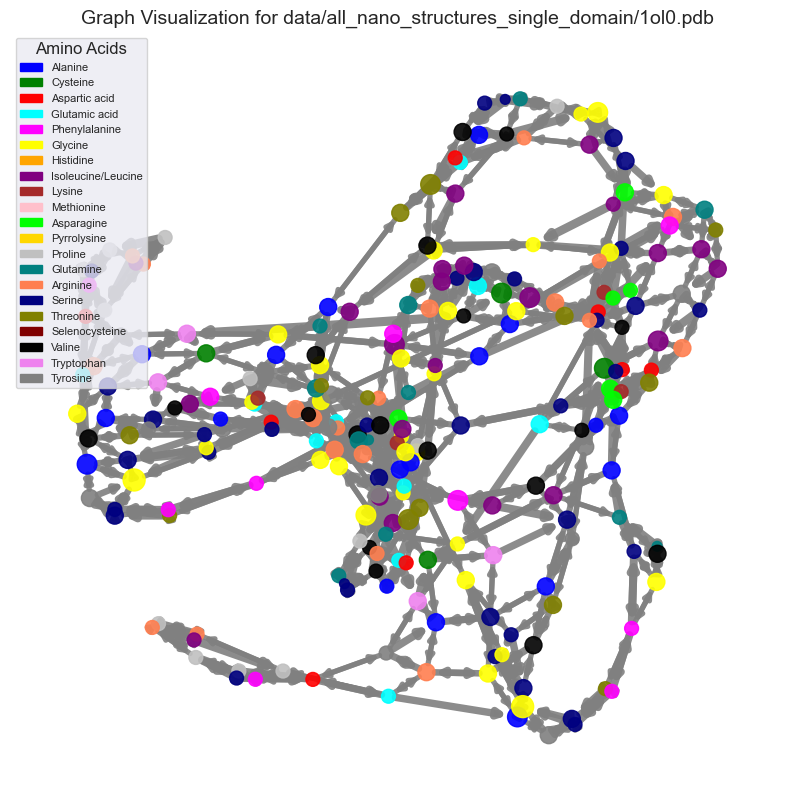

In [13]:
# Example
pdb_file, data = graphs[10]
visualize_nanobody_graph_aminoacids(data, pdb_file)

# Dataloader

# Prepare Graphs for VAE with normalization 

In [174]:
import torch
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import matplotlib.pyplot as plt

def prepare_graphs_for_vae(graph_tuples, batch_size=16, train_ratio=0.8, shuffle=True):
    """
    Prepare PDB graph data for VAE training with robust normalization
    """
    # Extract PyG Data objects
    graphs = [g[1] for g in graph_tuples]

    # Calculate robust normalization statistics across all graphs
    all_features = torch.cat([g.x for g in graphs], dim=0)

    # Calculate means and stds for each feature type separately
    mass_mean, mass_std = all_features[:, 0].mean(), all_features[:, 0].std()
    dist_mean = all_features[:, 1:3].mean()
    dist_std = all_features[:, 1:3].std()
    count_mean, count_std = all_features[:, 3].mean(), all_features[:, 3].std()
    # Small molecule features (binary) don't need normalization
    coords_mean = all_features[:, 5:].mean()
    coords_std = all_features[:, 5:].std()

    # Prevent division by zero
    eps = 1e-6
    mass_std = torch.max(mass_std, torch.tensor(eps))
    dist_std = torch.max(dist_std, torch.tensor(eps))
    count_std = torch.max(count_std, torch.tensor(eps))
    coords_std = torch.max(coords_std, torch.tensor(eps))

    # Normalize all graphs with feature-specific normalization
    for graph in graphs:
        # Mass normalization
        graph.x[:, 0] = (graph.x[:, 0] - mass_mean) / mass_std

        # Distance normalization
        graph.x[:, 1:3] = (graph.x[:, 1:3] - dist_mean) / dist_std

        # Count normalization
        graph.x[:, 3] = (graph.x[:, 3] - count_mean) / count_std

        # Small molecule features left as is (binary)
        # graph.x[:, 4] remains unchanged

        # Coordinate normalization
        graph.x[:, 5:] = (graph.x[:, 5:] - coords_mean) / coords_std

        # Edge attribute normalization
        if graph.edge_attr is not None:
            edge_mean = graph.edge_attr.mean()
            edge_std = torch.max(graph.edge_attr.std(), torch.tensor(eps))
            graph.edge_attr = (graph.edge_attr - edge_mean) / edge_std

    # Train/test split and loader creation
    train_graphs, test_graphs = train_test_split(
        graphs,
        train_size=train_ratio,
        shuffle=shuffle,
        random_state=42
    )

    train_loader = DataLoader(
        train_graphs,
        batch_size=batch_size,
        shuffle=shuffle
    )

    test_loader = DataLoader(
        test_graphs,
        batch_size=batch_size,
        shuffle=False
    )

    sample_data = train_graphs[0]
    in_channels = sample_data.x.size(1)

    print(f"\nDataset prepared:")
    print(f"Number of training graphs: {len(train_graphs)}")
    print(f"Number of test graphs: {len(test_graphs)}")
    print(f"Number of features per node: {in_channels}")
    print(f"\nNormalization statistics:")
    print(f"Mass - mean: {mass_mean:.4f}, std: {mass_std:.4f}")
    print(f"Distances - mean: {dist_mean:.4f}, std: {dist_std:.4f}")
    print(f"Count - mean: {count_mean:.4f}, std: {count_std:.4f}")
    print(f"Coordinates - mean: {coords_mean:.4f}, std: {coords_std:.4f}")

    # Return normalization parameters
    norm_params = {
        'mass': (mass_mean, mass_std),
        'dist': (dist_mean, dist_std),
        'count': (count_mean, count_std),
        'coords': (coords_mean, coords_std)
    }

    return train_loader, test_loader, in_channels, norm_params



# Define Graph GAT VAE Architecture

In [201]:
class ProteinGraphVAE(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_channels=32, num_heads=4, edge_dim=1):
        super(ProteinGraphVAE, self).__init__()

        # Model parameters
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.latent_channels = latent_channels
        self.edge_dim = edge_dim
        self.training_factor = nn.Parameter(torch.zeros(1))

        # Feature indices
        self.coord_indices = slice(-3, None)
        self.mass_index = 0
        self.distance_indices = slice(1, 3)
        self.count_index = 3
        self.small_mol_index = 4

        # Loss weights
        self.loss_weights = {
            'mass': 1.0,
            'distance': 1.0,
            'count': 1.0,
            'small_mol': 1.0,
            'coord': 1.0,
            'edge': 1.0
        }

        # Encoder with GAT layers
        self.encoder_layers = nn.ModuleList([
            GATConv(in_channels, hidden_channels, heads=4, edge_dim=edge_dim),
            GATConv(hidden_channels * 4, hidden_channels, heads=2, edge_dim=edge_dim),
            GATConv(hidden_channels * 2, hidden_channels, heads=1, edge_dim=edge_dim)
        ])

        # Encoder feedforward
        self.encoder_ff = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU()
        )

        # Direct latent projections
        self.fc_mu = nn.Linear(hidden_channels, latent_channels)
        self.fc_logvar = nn.Linear(hidden_channels, latent_channels)

        # Decoder
        self.shared_decoder = nn.Sequential(
            nn.Linear(latent_channels, hidden_channels),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels),
            nn.Dropout(0.2),
            nn.Linear(hidden_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.Linear(hidden_channels * 2, hidden_channels)
        )

        # Feature-specific heads
        self.coord_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 3),
            nn.Tanh()
        )

        self.mass_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, 1),
            nn.Softplus()
        )

        self.distance_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 2),
            nn.Softplus()
        )

        self.count_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, 1),
            nn.Softplus()
        )

        self.small_mol_head = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, 1)
        )

        self.edge_decoder = nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_channels, edge_dim),
            nn.Softplus()
        )

        self.init_weights()

    def init_weights(self):
        nn.init.xavier_normal_(self.fc_mu.weight, gain=2.0)
        nn.init.zeros_(self.fc_mu.bias)
        nn.init.xavier_normal_(self.fc_logvar.weight, gain=2.0)
        nn.init.constant_(self.fc_logvar.bias, 1.0)

    def encode(self, x, edge_index, edge_attr, batch):
        for conv in self.encoder_layers:
            x = conv(x, edge_index, edge_attr=edge_attr)
            x = F.relu(x)
            x = F.dropout(x, p=0.1, training=self.training)

        x = self.encoder_ff(x)
        x = global_mean_pool(x, batch)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decode(self, z, num_nodes, edge_index):
        batch_size = z.size(0)

        # Add position-specific noise with learned scaling
        z = z.unsqueeze(1).expand(-1, num_nodes, -1)
        noise_scale = torch.sigmoid(self.training_factor) * 0.1
        position_noise = torch.randn_like(z) * noise_scale
        z = z + position_noise
        z = z.reshape(-1, self.latent_channels)

        # Shared decoding
        h = self.shared_decoder(z)

        # Feature-specific decoding
        coords = self.coord_head(h) * 10  # Scale coordinates appropriately
        mass = self.mass_head(h)
        distances = self.distance_head(h)
        counts = self.count_head(h)
        small_mols = self.small_mol_head(h)

        # Edge decoding
        row, col = edge_index
        edge_features = torch.cat([h[row], h[col]], dim=1)
        decoded_edges = self.edge_decoder(edge_features)

        # Combine features
        features = torch.cat([mass, distances, counts, small_mols, coords], dim=1)
        return features.view(batch_size, num_nodes, -1), decoded_edges

    def feature_specific_loss(self, recon, target, edge_recon, edge_target):
        losses = {}
        EPS = 1e-6

        # Calculate losses without additional normalization
        mass_pred = F.softplus(recon[..., self.mass_index])
        mass_target = target[..., self.mass_index]
        losses['mass'] = F.mse_loss(mass_pred, mass_target) * self.loss_weights['mass']

        dist_pred = F.softplus(recon[..., self.distance_indices])
        dist_target = target[..., self.distance_indices]
        losses['distance'] = F.mse_loss(dist_pred, dist_target) * self.loss_weights['distance']

        count_pred = F.softplus(recon[..., self.count_index])
        count_target = target[..., self.count_index]
        losses['count'] = F.mse_loss(count_pred, count_target) * self.loss_weights['count']

        small_mol_pred = recon[..., self.small_mol_index]
        small_mol_target = target[..., self.small_mol_index].clamp(0, 1)
        losses['small_mol'] = F.binary_cross_entropy_with_logits(
            small_mol_pred, small_mol_target, reduction='mean'
        ) * self.loss_weights['small_mol']

        coord_pred = recon[..., self.coord_indices]
        coord_target = target[..., self.coord_indices]
        losses['coord'] = F.mse_loss(coord_pred, coord_target) * self.loss_weights['coord']

        edge_pred = F.softplus(edge_recon)
        edge_target_pos = F.softplus(edge_target)
        losses['edge'] = F.mse_loss(edge_pred, edge_target_pos) * self.loss_weights['edge']

        total_loss = sum(loss for loss in losses.values() if torch.isfinite(loss))

        return total_loss, losses

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def forward(self, x, edge_index, edge_attr, batch):
        mu, logvar = self.encode(x, edge_index, edge_attr, batch)
        z = self.reparameterize(mu, logvar)

        unique, counts = torch.unique(batch, return_counts=True)
        max_nodes = counts.max().item()

        recon, edge_recon = self.decode(z, max_nodes, edge_index)
        return recon, edge_recon, mu, logvar

# Training model

In [202]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def kl_annealing_factor(epoch, warmup_epochs=10, min_weight=0.0001, max_weight=1.0):
    """Compute KL annealing factor that gradually increases from min_weight to max_weight"""
    if epoch < warmup_epochs:
        return min_weight + (max_weight - min_weight) * (epoch / warmup_epochs)
    return max_weight

def compute_orthogonal_regularization(mu, lambda_ortho=0.1):
    """Compute orthogonality regularization for the latent space"""
    batch_size = mu.size(0)
    mu_normalized = F.normalize(mu, p=2, dim=1)  # Normalize each embedding
    correlation = torch.mm(mu_normalized.t(), mu_normalized) / batch_size
    identity = torch.eye(correlation.size(0), device=correlation.device)
    ortho_loss = lambda_ortho * torch.sum((correlation - identity) ** 2)
    return ortho_loss

def train_model(model, train_loader, test_loader, device, num_epochs=100,
                min_beta=0.0001, max_beta=0.01, warmup_epochs=10, lambda_ortho=0.1):
    """
    Train VAE model with KL annealing and orthogonal regularization
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    max_grad_norm = 1.0

    print(f"Starting training for {num_epochs} epochs...")
    print(f"Training on device: {device}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(test_loader)}")
    print(f"KL annealing: {min_beta} -> {max_beta} over {warmup_epochs} epochs")
    print(f"Orthogonal regularization strength: {lambda_ortho}")

    history = {
        'train': {
            'total_loss': [], 'recon_loss': [], 'kl_loss': [], 'ortho_loss': [],
            'mass_loss': [], 'distance_loss': [], 'count_loss': [],
            'small_mol_loss': [], 'coord_loss': [], 'edge_loss': [],
            'beta': []  # Track KL weight
        },
        'test': {
            'total_loss': [], 'recon_loss': [], 'kl_loss': [], 'ortho_loss': [],
            'mass_loss': [], 'distance_loss': [], 'count_loss': [],
            'small_mol_loss': [], 'coord_loss': [], 'edge_loss': []
        }
    }

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        epoch_losses = {k: 0.0 for k in history['train'].keys()}

        # Get current KL weight from annealing schedule
        current_beta = kl_annealing_factor(epoch, warmup_epochs, min_beta, max_beta)
        epoch_losses['beta'] = current_beta

        # Progress bar for training
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        batch_count = 0

        for batch in pbar:
            try:
                batch = batch.to(device)
                optimizer.zero_grad()

                # Debug info for first batch
                if batch_count == 0 and epoch == 0:
                    print(f"\nBatch shapes:")
                    print(f"Input x shape: {batch.x.shape}")
                    print(f"Edge index shape: {batch.edge_index.shape}")
                    print(f"Edge attr shape: {batch.edge_attr.shape}")

                # Forward pass
                recon_batch, edge_recon, mu, logvar = model(batch.x, batch.edge_index,
                                                            batch.edge_attr, batch.batch)

                if batch_count == 0 and epoch == 0:
                    print(f"Reconstruction shape: {recon_batch.shape}")
                    print(f"Edge reconstruction shape: {edge_recon.shape}")

                # Reshape original data
                _, counts = torch.unique(batch.batch, return_counts=True)
                max_nodes = counts.max()
                batch_size = len(counts)
                padded_x = torch.zeros(batch_size, max_nodes, batch.x.size(1), device=device)

                start_idx = 0
                for i, count in enumerate(counts):
                    padded_x[i, :count] = batch.x[start_idx:start_idx + count]
                    start_idx += count

                # Calculate losses
                recon_loss, feature_losses = model.feature_specific_loss(
                    recon_batch, padded_x, edge_recon, batch.edge_attr)

                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

                # Add orthogonality regularization
                ortho_loss = compute_orthogonal_regularization(mu, lambda_ortho)

                # Combine losses with annealed KL weight
                loss = recon_loss + current_beta * kl_loss + ortho_loss

                # Detailed diagnostics every 10 batches
                if batch_count % 10 == 0:
                    with torch.no_grad():
                        print("\nDetailed loss diagnostics:")
                        print(f"Raw recon_loss: {recon_loss.item():.4f}")
                        print(f"Raw KL loss: {kl_loss.item():.4f}")
                        print(f"Ortho loss: {ortho_loss.item():.4f}")
                        print(f"Current beta: {current_beta:.4f}")
                        print(f"mu mean: {mu.mean().item():.4f}, std: {mu.std().item():.4f}")
                        print(f"logvar mean: {logvar.mean().item():.4f}, std: {logvar.std().item():.4f}")
                        for k, v in feature_losses.items():
                            print(f"{k}: {v.item():.4f}")

                # Backward pass with gradient clipping
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                # Update progress bar and losses
                batch_count += 1
                epoch_losses['total_loss'] += loss.item()
                epoch_losses['recon_loss'] += recon_loss.item()
                epoch_losses['kl_loss'] += kl_loss.item()
                epoch_losses['ortho_loss'] += ortho_loss.item()
                for k, v in feature_losses.items():
                    epoch_losses[f'{k}_loss'] += v.item()

                # Update progress bar description
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'recon': f'{recon_loss.item():.4f}',
                    'kl': f'{kl_loss.item():.4f}',
                    'ortho': f'{ortho_loss.item():.4f}'
                })

            except Exception as e:
                print(f"\nError in batch {batch_count}:")
                print(str(e))
                print("Batch details:")
                print(f"Batch size: {batch.num_graphs}")
                print(f"Number of nodes: {batch.num_nodes}")
                print(f"Number of edges: {batch.num_edges}")
                continue

        # Average losses
        num_batches = len(train_loader)
        for k in epoch_losses:
            if k != 'beta':  # Don't average the beta value
                epoch_losses[k] = epoch_losses[k] / num_batches
            history['train'][k].append(epoch_losses[k])

        # Validation phase
        model.eval()
        test_losses = {k: 0.0 for k in history['test'].keys()}

        print("\nStarting validation...")
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]'):
                batch = batch.to(device)
                recon_batch, edge_recon, mu, logvar = model(batch.x, batch.edge_index,
                                                            batch.edge_attr, batch.batch)

                # Reshape original data
                _, counts = torch.unique(batch.batch, return_counts=True)
                max_nodes = counts.max()
                batch_size = len(counts)
                padded_x = torch.zeros(batch_size, max_nodes, batch.x.size(1), device=device)

                start_idx = 0
                for i, count in enumerate(counts):
                    padded_x[i, :count] = batch.x[start_idx:start_idx + count]
                    start_idx += count

                recon_loss, feature_losses = model.feature_specific_loss(
                    recon_batch, padded_x, edge_recon, batch.edge_attr)
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                ortho_loss = compute_orthogonal_regularization(mu, lambda_ortho)
                loss = recon_loss + current_beta * kl_loss + ortho_loss

                test_losses['total_loss'] += loss.item()
                test_losses['recon_loss'] += recon_loss.item()
                test_losses['kl_loss'] += kl_loss.item()
                test_losses['ortho_loss'] += ortho_loss.item()
                for k, v in feature_losses.items():
                    test_losses[f'{k}_loss'] += v.item()

        # Average test losses
        for k in test_losses:
            test_losses[k] /= len(test_loader)
            history['test'][k].append(test_losses[k])

        epoch_time = time.time() - epoch_start_time

        # Print epoch summary
        print(f'\nEpoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f}s')
        print(f'Train - Total: {epoch_losses["total_loss"]:.4f}, '
              f'Recon: {epoch_losses["recon_loss"]:.4f}, '
              f'KL: {epoch_losses["kl_loss"]:.4f}, '
              f'Ortho: {epoch_losses["ortho_loss"]:.4f}, '
              f'Beta: {current_beta:.4f}')
        print('Feature Losses:')
        for k in ['mass_loss', 'distance_loss', 'count_loss',
                  'small_mol_loss', 'coord_loss', 'edge_loss']:
            print(f'  {k}: {epoch_losses[k]:.4f}')

        # Plot training progress
        if (epoch + 1) % 1 == 0:  # Plot every epoch
            plt.figure(figsize=(20, 10))

            # Plot 1: Total, Reconstruction, KL, and Ortho losses
            plt.subplot(2, 2, 1)
            plt.plot(history['train']['total_loss'], label='Total Loss')
            plt.plot(history['train']['recon_loss'], label='Reconstruction Loss')
            plt.plot(history['train']['kl_loss'], label='KL Loss')
            plt.plot(history['train']['ortho_loss'], label='Ortho Loss')
            plt.plot(history['train']['beta'], label='Beta (KL weight)')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Losses')
            plt.legend()
            plt.grid(True)

            # Plot 2: Feature-specific losses
            plt.subplot(2, 2, 2)
            for k in ['mass_loss', 'distance_loss', 'count_loss',
                      'small_mol_loss', 'coord_loss', 'edge_loss']:
                plt.plot(history['train'][k], label=k.replace('_loss', ''))
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Feature-specific Losses')
            plt.legend()
            plt.grid(True)

            # Plot 3: Feature-specific losses (log scale)
            plt.subplot(2, 2, 3)
            for k in ['mass_loss', 'distance_loss', 'count_loss',
                      'small_mol_loss', 'coord_loss', 'edge_loss']:
                values = [max(1e-10, abs(x)) for x in history['train'][k]]
                plt.semilogy(values, label=k.replace('_loss', ''))
            plt.xlabel('Epoch')
            plt.ylabel('Loss (log scale)')
            plt.title('Feature-specific Losses (Log Scale)')
            plt.legend()
            plt.grid(True)

            # Plot 4: Training vs Validation losses
            plt.subplot(2, 2, 4)
            plt.plot(history['train']['total_loss'], label='Train Loss')
            plt.plot(history['test']['total_loss'], label='Val Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training vs Validation Loss')
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()

    print("\nTraining completed!")
    return model, history

# Some model info

In [203]:
# First, instantiate the model
model = ProteinGraphVAE(
    in_channels=8,
    hidden_channels=64,
    latent_channels=16,
    num_heads=4,
    edge_dim=1
)

# Print model structure and parameter count
print("Model structure:")
print(model)

print("\nParameter count by layer:")
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()} parameters")
        total_params += param.numel()
print(f"\nTotal trainable parameters: {total_params}")

Model structure:
ProteinGraphVAE(
  (encoder_layers): ModuleList(
    (0): GATConv(8, 64, heads=4)
    (1): GATConv(256, 64, heads=2)
    (2): GATConv(128, 64, heads=1)
  )
  (encoder_ff): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
  )
  (fc_mu): Linear(in_features=64, out_features=16, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=16, bias=True)
  (shared_decoder): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=128, out_features=64, bias=True)
  )
  (coo

In [178]:
device=get_device()

INFO:__main__:MPS (M1/M2) device found but using CPU for some operations due to compatibility


# Plot the latent space pre training to check its not nonsense -> @ lara maybe your plot is better ??

In [204]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

def plot_latent_space(model, data_loader, device, method='pca'):
    """
    Plot the latent space of the model using PCA or t-SNE.

    Args:
        model: Trained ProteinGraphVAE model.
        data_loader: DataLoader containing the data.
        device: torch device.
        method: Dimensionality reduction method ('pca' or 'tsne').

    Returns:
        None
    """
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu().numpy())
            labels.append(batch.batch.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=300)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")

    reduced_latent = reducer.fit_transform(latent_vectors)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], c=labels[:reduced_latent.shape[0]], cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Batch')
    plt.title(f'Latent Space Visualization ({method.upper()})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

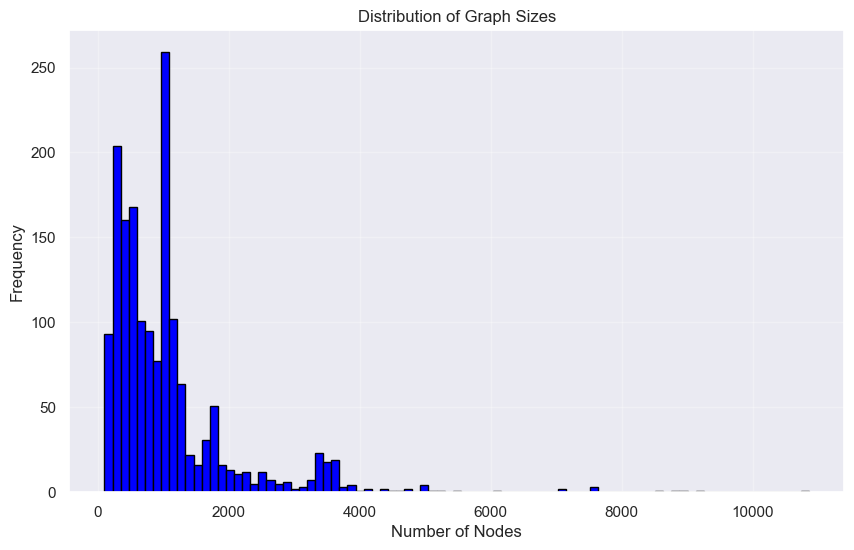

In [239]:
import matplotlib.pyplot as plt

def plot_graph_sizes(graph_tuples):
    """
    Creates a simple histogram of graph sizes from a list of graph tuples.
    
    Args:
        graph_tuples: List of tuples where graph is the second element
    """
    # Get number of nodes for each graph
    node_counts = [g[1].x.size(0) for g in graph_tuples]

    # Create histogram
    plt.figure(figsize=(10, 6))
    plt.hist(node_counts, bins='auto', color='blue', edgecolor='black')
    plt.title('Distribution of Graph Sizes')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()

# Example usage:
plot_graph_sizes(graphs)

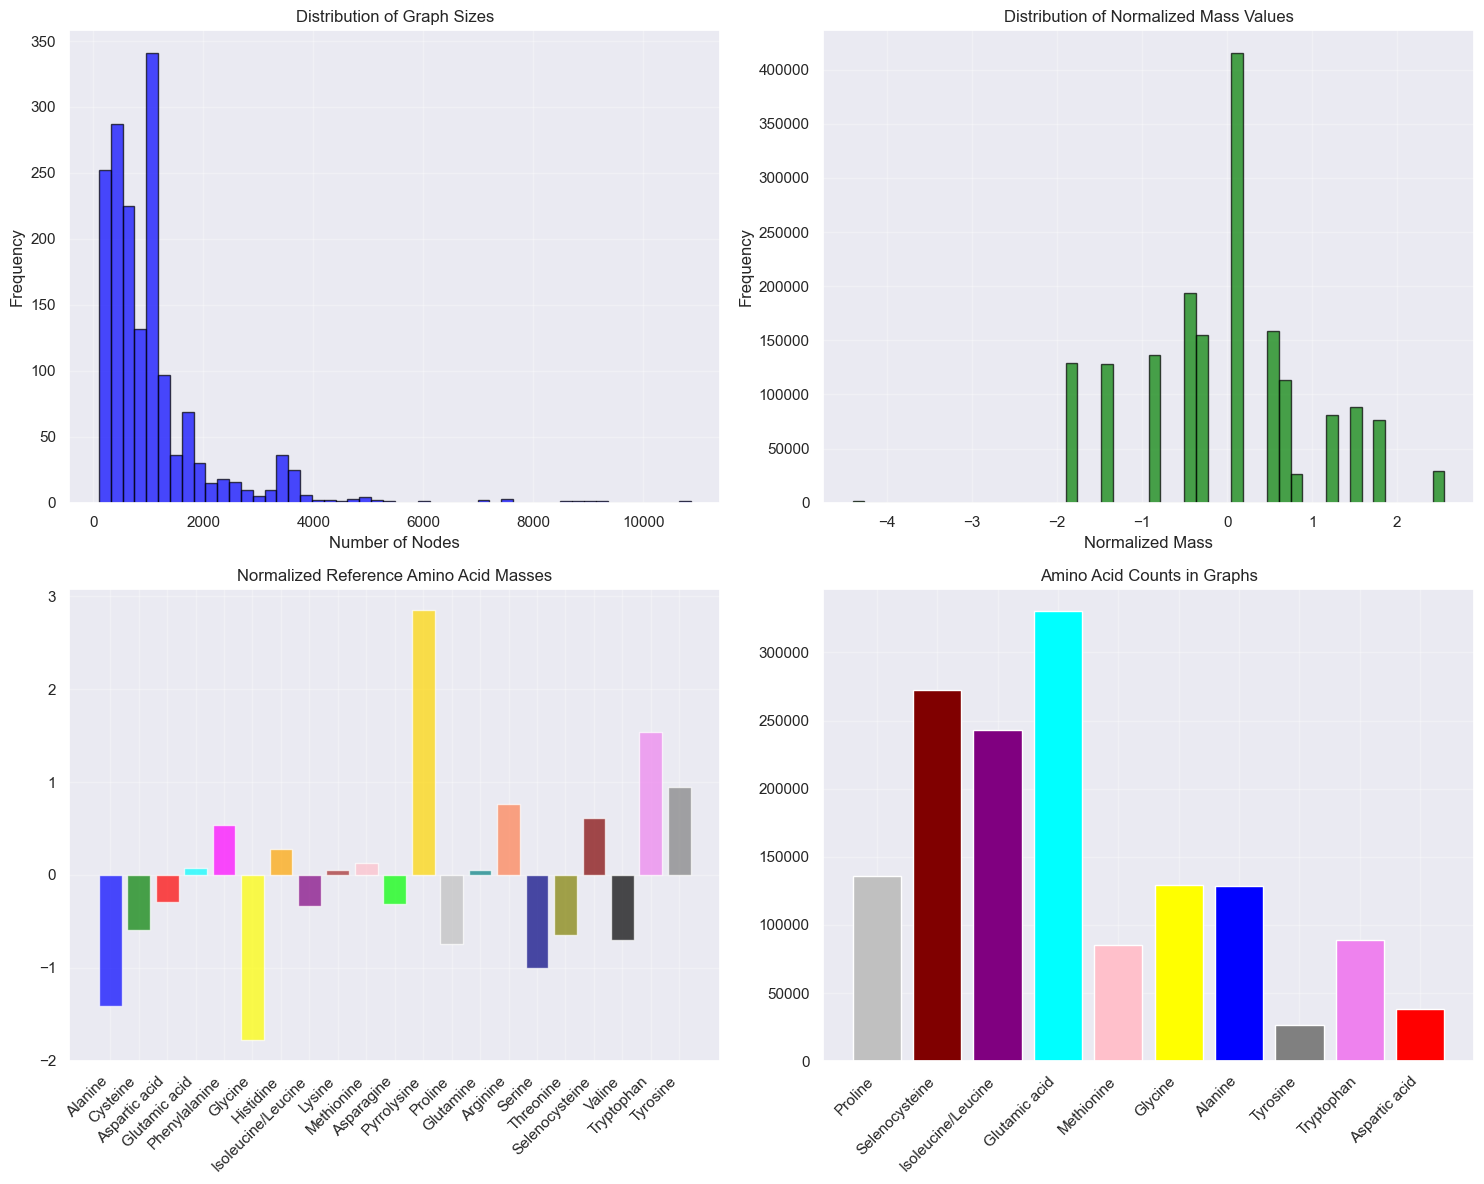


Graph statistics:
Total graphs: 1636
Average nodes per graph: 1059.9

Amino acid counts:
Proline: 136151 (9.2%)
Selenocysteine: 272465 (18.4%)
Isoleucine/Leucine: 243232 (16.4%)
Glutamic acid: 330052 (22.3%)
Methionine: 85430 (5.8%)
Glycine: 129120 (8.7%)
Alanine: 128291 (8.7%)
Tyrosine: 26799 (1.8%)
Tryptophan: 88771 (6.0%)
Aspartic acid: 38689 (2.6%)


In [248]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import torch

def analyze_amino_acids(graph_tuples, amino_acid_data):
    """
    Analyzes graph sizes and tries to match normalized mass values to amino acids.
    
    Args:
        graph_tuples: List of tuples where each tuple is (path, graph)
        amino_acid_data: List of tuples (mass, name, color) for amino acids
    """
    # Get the graphs
    graphs = [g[1] for g in graph_tuples]

    # Create figure
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Plot graph size distribution
    node_counts = [g.x.size(0) for g in graphs]
    ax1.hist(node_counts, bins=50, color='blue', edgecolor='black', alpha=0.7)
    ax1.set_title('Distribution of Graph Sizes')
    ax1.set_xlabel('Number of Nodes')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)

    # Get all mass values
    all_masses = torch.cat([g.x[:, 0] for g in graphs])

    # 2. Plot mass value distribution
    ax2.hist(all_masses.cpu().numpy(), bins=50, color='green', edgecolor='black', alpha=0.7)
    ax2.set_title('Distribution of Normalized Mass Values')
    ax2.set_xlabel('Normalized Mass')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)

    # 3. Calculate normalized amino acid masses
    aa_masses = np.array([mass for mass, _, _ in amino_acid_data])
    aa_names = [name for _, name, _ in amino_acid_data]
    aa_colors = [color for _, _, color in amino_acid_data]

    # Normalize amino acid masses
    aa_masses_normalized = (aa_masses - np.mean(aa_masses)) / np.std(aa_masses)

    # 4. Plot amino acid mass distribution
    ax3.bar(range(len(aa_masses_normalized)), aa_masses_normalized,
            color=aa_colors, alpha=0.7)
    ax3.set_title('Normalized Reference Amino Acid Masses')
    ax3.set_xticks(range(len(aa_names)))
    ax3.set_xticklabels(aa_names, rotation=45, ha='right')
    ax3.grid(True, alpha=0.3)

    # 5. Match nodes to amino acids and count
    aa_counts = defaultdict(int)
    tolerance = 0.1  # Adjust this value based on results

    for mass in all_masses:
        mass = mass.item()
        # Find closest amino acid
        distances = np.abs(aa_masses_normalized - mass)
        min_idx = np.argmin(distances)
        if distances[min_idx] < tolerance:
            aa_counts[aa_names[min_idx]] += 1

    # Plot amino acid counts
    names = list(aa_counts.keys())
    counts = list(aa_counts.values())
    colors = [aa_colors[aa_names.index(name)] for name in names]

    ax4.bar(range(len(counts)), counts, color=colors)
    ax4.set_title('Amino Acid Counts in Graphs')
    ax4.set_xticks(range(len(names)))
    ax4.set_xticklabels(names, rotation=45, ha='right')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\nGraph statistics:")
    print(f"Total graphs: {len(graphs)}")
    print(f"Average nodes per graph: {np.mean(node_counts):.1f}")
    print(f"\nAmino acid counts:")
    total_matched = sum(aa_counts.values())
    for aa, count in aa_counts.items():
        print(f"{aa}: {count} ({count/total_matched*100:.1f}%)")

# Example usage:
analyze_amino_acids(graphs, AMINO_ACID_DATA)

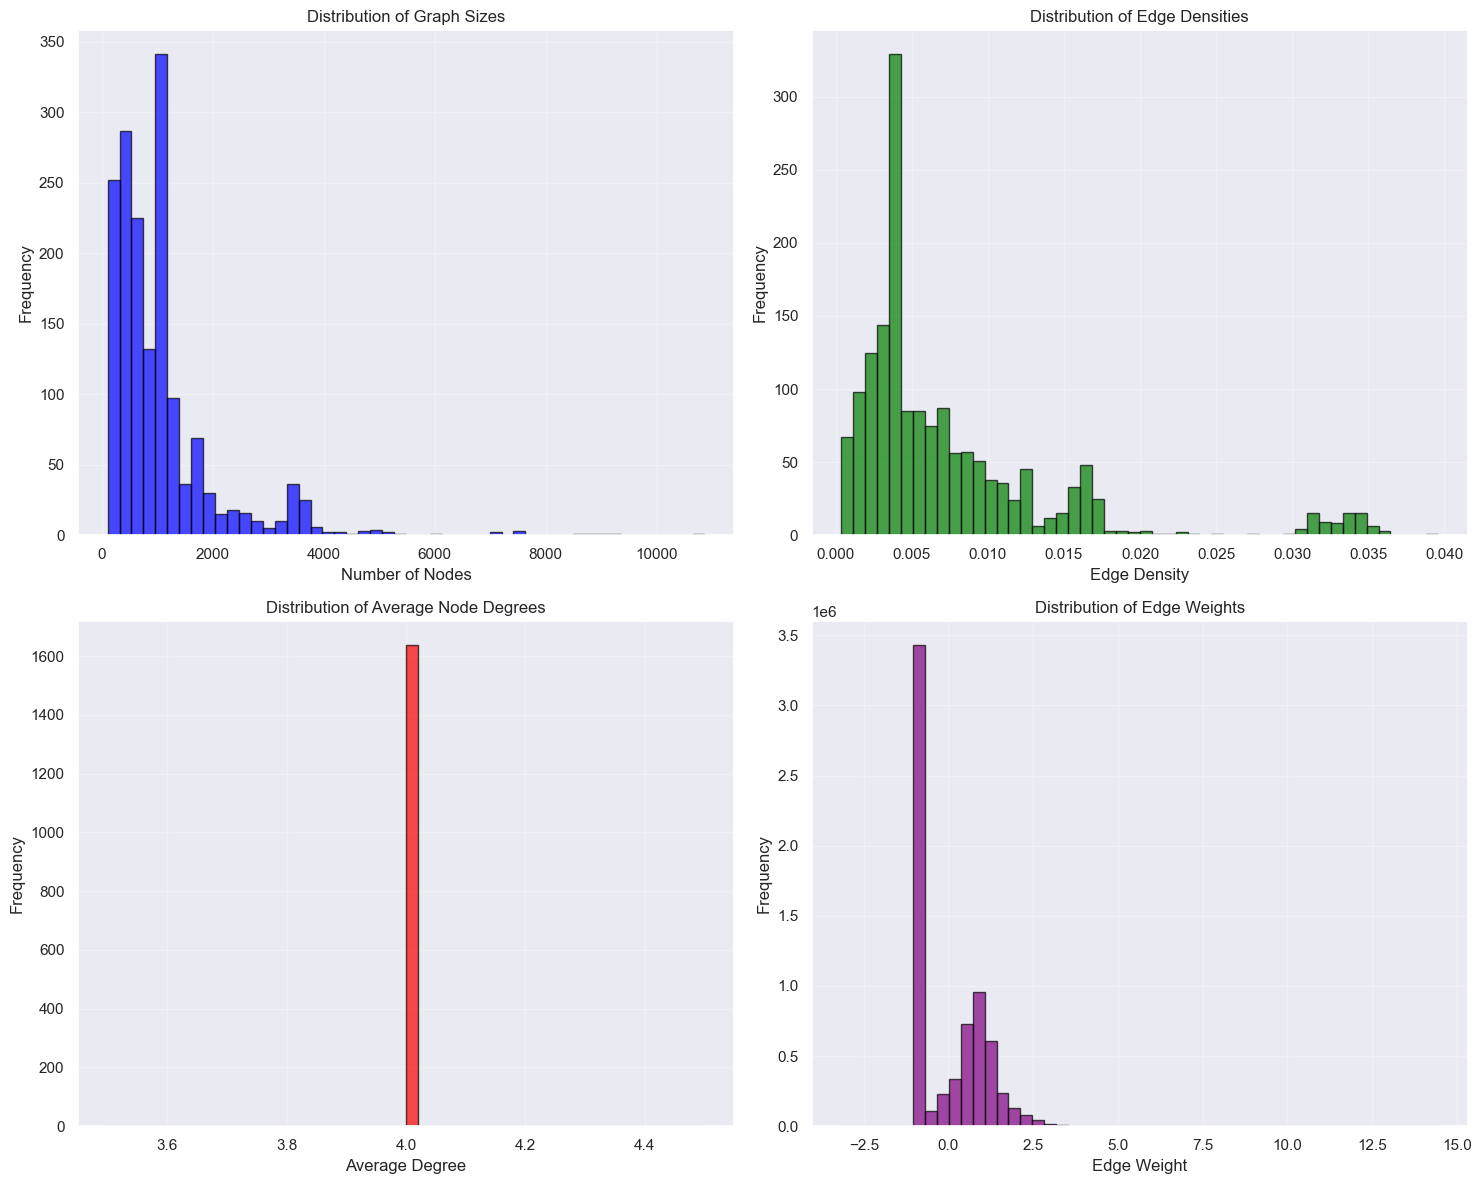


Graph Statistics:
Number of graphs: 1636

Node counts:
  Mean: 1059.9
  Median: 839.0
  Min: 102
  Max: 10858

Edge density:
  Mean: 0.0076
  Median: 0.0048

Average node degree:
  Mean: 4.00
  Median: 4.00


In [249]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import torch

def analyze_protein_properties(graph_tuples, amino_acid_data):
    """
    Analyzes various properties of protein graphs.
    
    Args:
        graph_tuples: List of tuples where each tuple is (path, graph)
        amino_acid_data: List of tuples (mass, name, color) for amino acids
    """
    # Create figure with multiple subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Get the graphs
    graphs = [g[1] for g in graph_tuples]

    # 1. Graph size distribution
    node_counts = [g.x.size(0) for g in graphs]
    ax1.hist(node_counts, bins=50, color='blue', edgecolor='black', alpha=0.7)
    ax1.set_title('Distribution of Graph Sizes')
    ax1.set_xlabel('Number of Nodes')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)

    # 2. Edge density distribution
    edge_densities = []
    for g in graphs:
        n_nodes = g.x.size(0)
        n_edges = g.edge_index.size(1)
        density = n_edges / (n_nodes * (n_nodes - 1))  # Normalized by max possible edges
        edge_densities.append(density)

    ax2.hist(edge_densities, bins=50, color='green', edgecolor='black', alpha=0.7)
    ax2.set_title('Distribution of Edge Densities')
    ax2.set_xlabel('Edge Density')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)

    # 3. Average node degree distribution
    avg_degrees = []
    for g in graphs:
        n_nodes = g.x.size(0)
        n_edges = g.edge_index.size(1)
        avg_degree = n_edges / n_nodes
        avg_degrees.append(avg_degree)

    ax3.hist(avg_degrees, bins=50, color='red', edgecolor='black', alpha=0.7)
    ax3.set_title('Distribution of Average Node Degrees')
    ax3.set_xlabel('Average Degree')
    ax3.set_ylabel('Frequency')
    ax3.grid(True, alpha=0.3)

    # 4. Edge weight distribution (if available)
    if hasattr(graphs[0], 'edge_attr') and graphs[0].edge_attr is not None:
        edge_weights = torch.cat([g.edge_attr for g in graphs])
        ax4.hist(edge_weights.cpu().numpy(), bins=50, color='purple', edgecolor='black', alpha=0.7)
        ax4.set_title('Distribution of Edge Weights')
        ax4.set_xlabel('Edge Weight')
        ax4.set_ylabel('Frequency')
    else:
        # Alternative: Plot size vs edges correlation
        sizes = np.array(node_counts)
        edges = np.array([g.edge_index.size(1) for g in graphs])
        ax4.scatter(sizes, edges, alpha=0.5, color='purple')
        ax4.set_title('Graph Size vs Number of Edges')
        ax4.set_xlabel('Number of Nodes')
        ax4.set_ylabel('Number of Edges')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\nGraph Statistics:")
    print(f"Number of graphs: {len(graphs)}")
    print(f"\nNode counts:")
    print(f"  Mean: {np.mean(node_counts):.1f}")
    print(f"  Median: {np.median(node_counts):.1f}")
    print(f"  Min: {np.min(node_counts)}")
    print(f"  Max: {np.max(node_counts)}")

    print(f"\nEdge density:")
    print(f"  Mean: {np.mean(edge_densities):.4f}")
    print(f"  Median: {np.median(edge_densities):.4f}")

    print(f"\nAverage node degree:")
    print(f"  Mean: {np.mean(avg_degrees):.2f}")
    print(f"  Median: {np.median(avg_degrees):.2f}")

# Example usage:
analyze_protein_properties(graphs, AMINO_ACID_DATA)

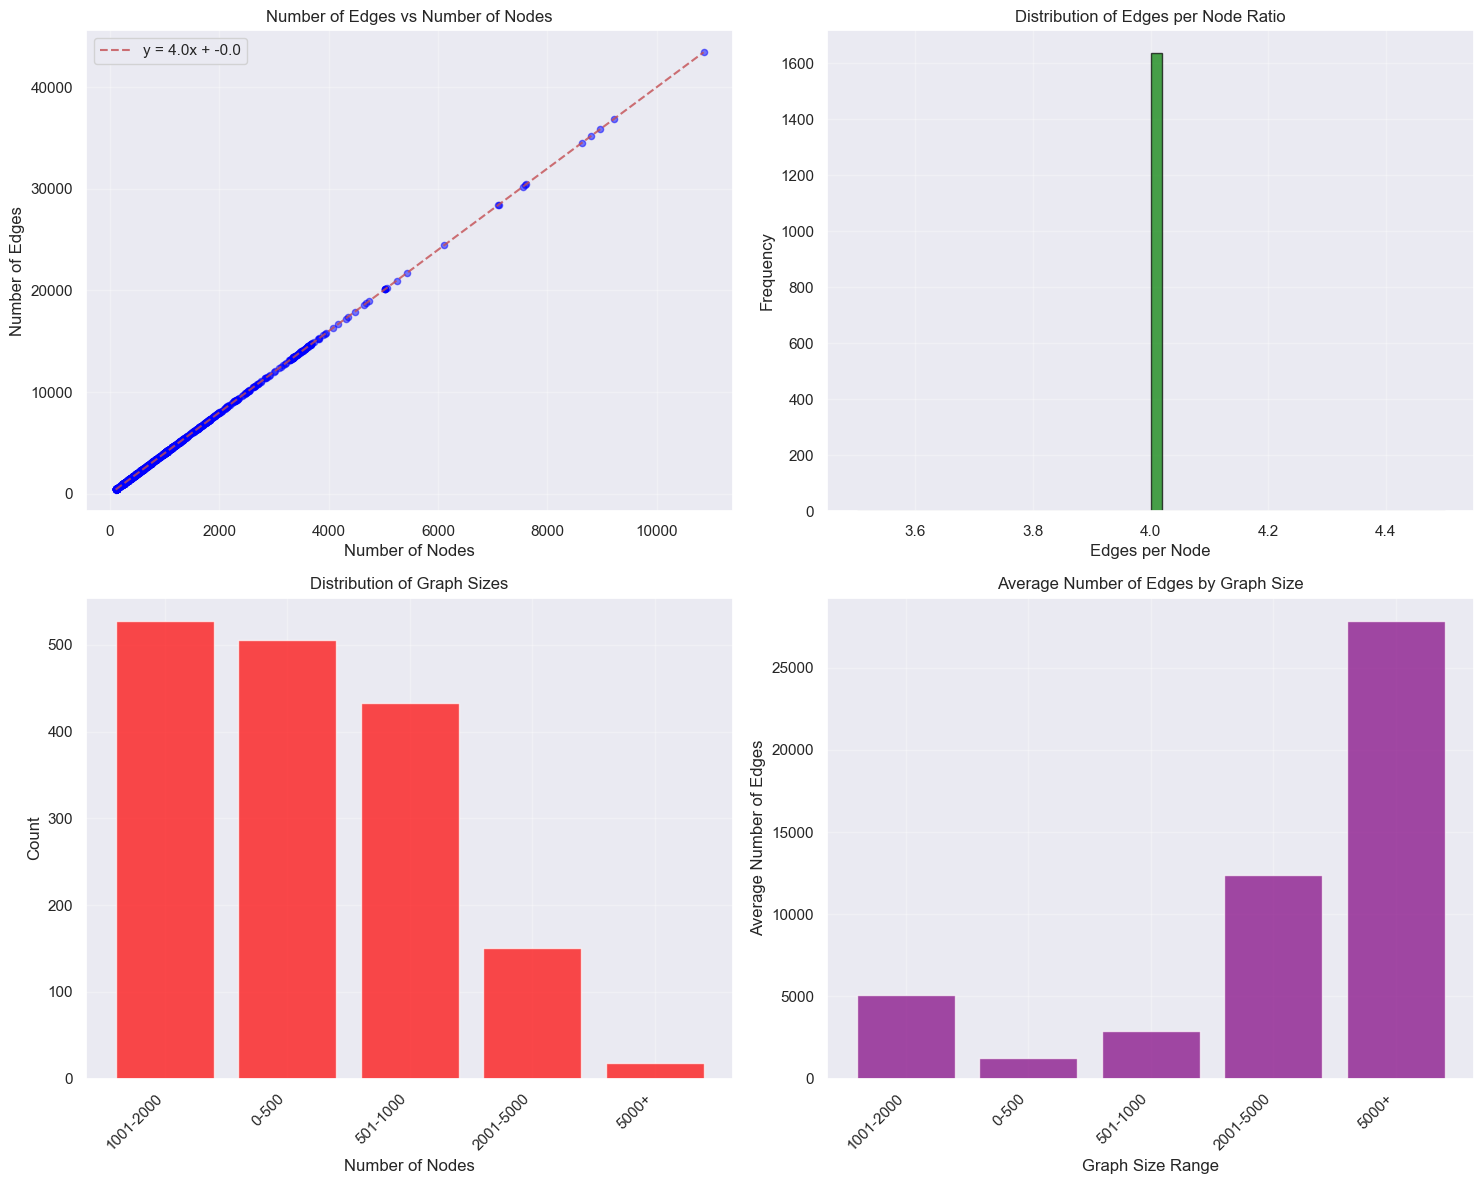


Graph Statistics:
Number of graphs: 1636

Node counts:
  Mean: 1059.9
  Median: 839.0
  Min: 102
  Max: 10858

Edges per node:
  Mean: 4.00
  Median: 4.00
  Std: 0.00

Size distribution:
  1001-2000: 528 graphs (32.3%)
  0-500: 506 graphs (30.9%)
  501-1000: 433 graphs (26.5%)
  2001-5000: 151 graphs (9.2%)
  5000+: 18 graphs (1.1%)


In [251]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from collections import defaultdict

def analyze_extended_properties(graph_tuples):
    """
    Analyzes additional properties of protein graphs.
    
    Args:
        graph_tuples: List of tuples where each tuple is (path, graph)
    """
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Get the graphs
    graphs = [g[1] for g in graph_tuples]

    # 1. Node count vs Edge count relationship
    node_counts = [g.x.size(0) for g in graphs]
    edge_counts = [g.edge_index.size(1) for g in graphs]

    ax1.scatter(node_counts, edge_counts, alpha=0.5, color='blue', s=20)
    ax1.set_title('Number of Edges vs Number of Nodes')
    ax1.set_xlabel('Number of Nodes')
    ax1.set_ylabel('Number of Edges')
    ax1.grid(True, alpha=0.3)

    # Add trend line
    z = np.polyfit(node_counts, edge_counts, 1)
    p = np.poly1d(z)
    x_trend = np.linspace(min(node_counts), max(node_counts), 100)
    ax1.plot(x_trend, p(x_trend), "r--", alpha=0.8, label=f'y = {z[0]:.1f}x + {z[1]:.1f}')
    ax1.legend()

    # 2. Distribution of edges per node ratio
    edges_per_node = [e/n for e, n in zip(edge_counts, node_counts)]
    ax2.hist(edges_per_node, bins=50, color='green', edgecolor='black', alpha=0.7)
    ax2.set_title('Distribution of Edges per Node Ratio')
    ax2.set_xlabel('Edges per Node')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)

    # 3. Graph size distribution by binned sizes
    size_bins = [0, 500, 1000, 2000, 5000, float('inf')]
    size_labels = ['0-500', '501-1000', '1001-2000', '2001-5000', '5000+']

    size_counts = defaultdict(int)
    for n in node_counts:
        for i, (low, high) in enumerate(zip(size_bins[:-1], size_bins[1:])):
            if low <= n < high:
                size_counts[size_labels[i]] += 1
                break

    ax3.bar(size_counts.keys(), size_counts.values(), color='red', alpha=0.7)
    ax3.set_title('Distribution of Graph Sizes')
    ax3.set_xlabel('Number of Nodes')
    ax3.set_ylabel('Count')
    plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')
    ax3.grid(True, alpha=0.3)

    # 4. Average number of edges by size bin
    edges_by_bin = defaultdict(list)
    for n, e in zip(node_counts, edge_counts):
        for i, (low, high) in enumerate(zip(size_bins[:-1], size_bins[1:])):
            if low <= n < high:
                edges_by_bin[size_labels[i]].append(e)
                break

    avg_edges = [np.mean(edges) if edges else 0 for edges in edges_by_bin.values()]
    ax4.bar(edges_by_bin.keys(), avg_edges, color='purple', alpha=0.7)
    ax4.set_title('Average Number of Edges by Graph Size')
    ax4.set_xlabel('Graph Size Range')
    ax4.set_ylabel('Average Number of Edges')
    plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\nGraph Statistics:")
    print(f"Number of graphs: {len(graphs)}")
    print(f"\nNode counts:")
    print(f"  Mean: {np.mean(node_counts):.1f}")
    print(f"  Median: {np.median(node_counts):.1f}")
    print(f"  Min: {min(node_counts)}")
    print(f"  Max: {max(node_counts)}")

    print(f"\nEdges per node:")
    print(f"  Mean: {np.mean(edges_per_node):.2f}")
    print(f"  Median: {np.median(edges_per_node):.2f}")
    print(f"  Std: {np.std(edges_per_node):.2f}")

    print("\nSize distribution:")
    for size_range, count in size_counts.items():
        print(f"  {size_range}: {count} graphs ({count/len(graphs)*100:.1f}%)")

# Example usage:
analyze_extended_properties(graphs)

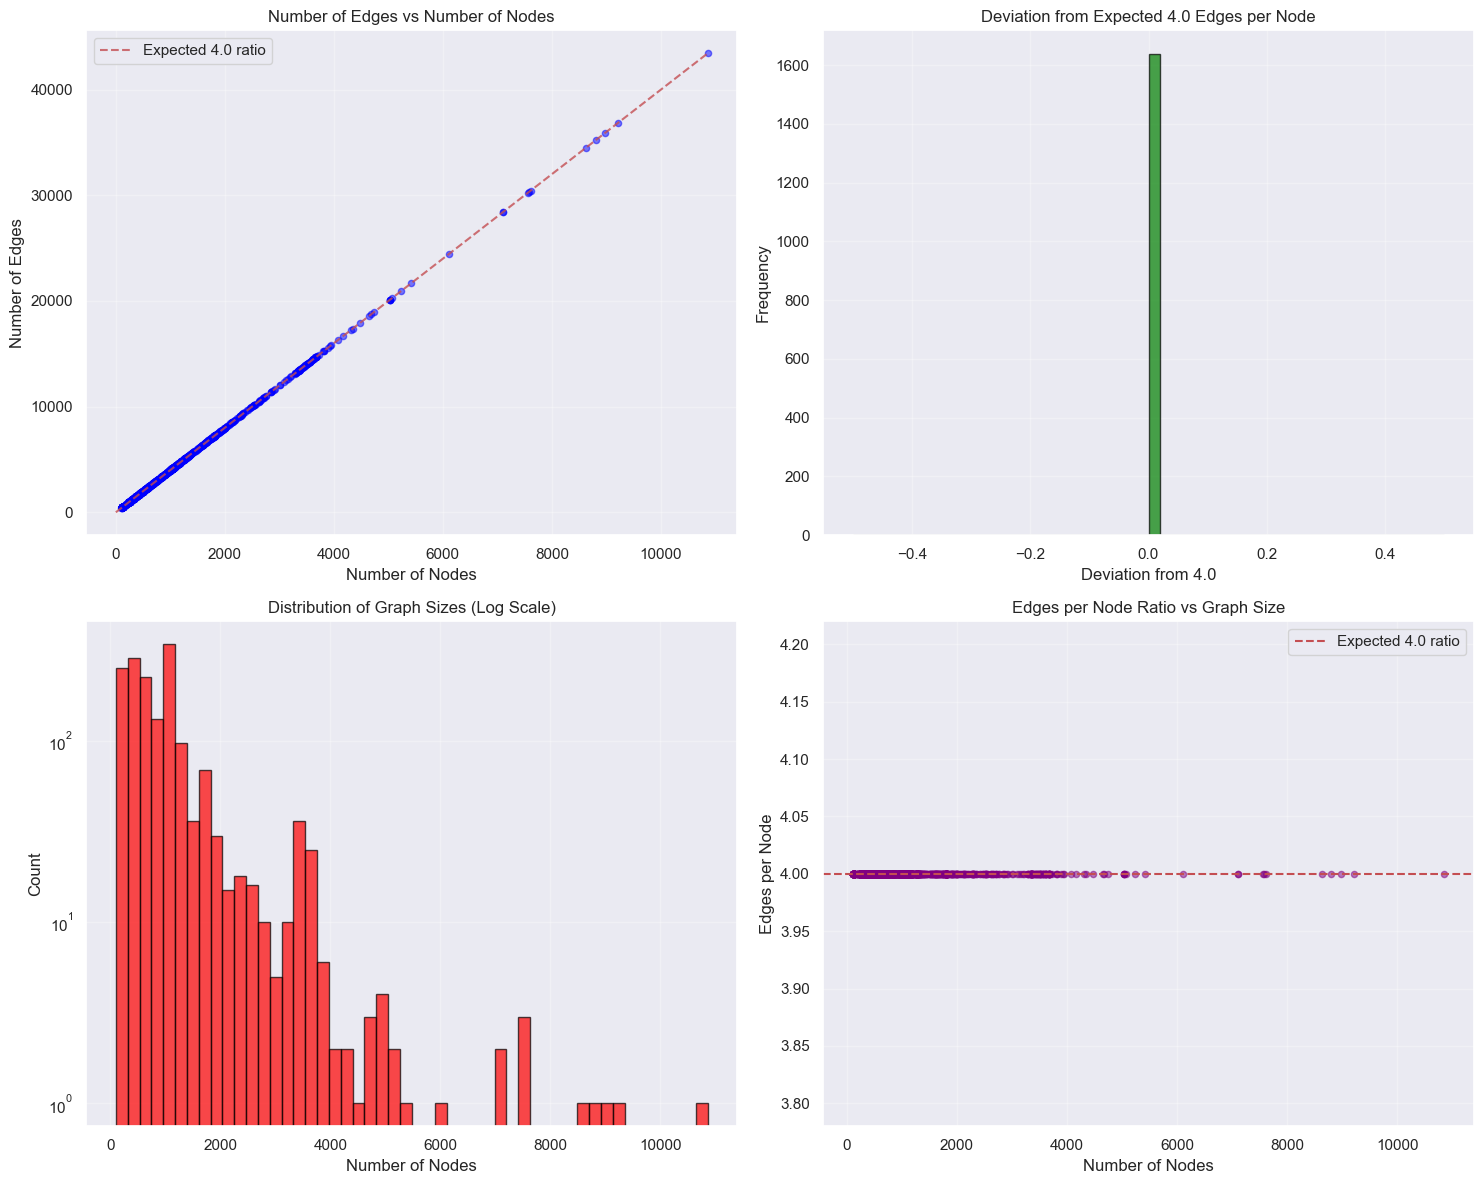


Graph Statistics:
Number of graphs: 1636

Connectivity Analysis:
Average edges per node: 4.0000
Std dev of ratio: 0.0000
Max deviation from 4.0: 0.0000

Size Distribution:
10th percentile: 250 nodes
25th percentile: 430 nodes
50th percentile: 839 nodes
75th percentile: 1166 nodes
90th percentile: 2086 nodes


In [253]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def analyze_protein_graphs(graph_tuples):
    """
    Analyzes protein graph properties with focus on connectivity patterns.
    
    Args:
        graph_tuples: List of tuples where each tuple is (path, graph)
    """
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Get the graphs
    graphs = [g[1] for g in graph_tuples]

    # 1. Node count vs Edge count with perfect 4.0 ratio line
    node_counts = [g.x.size(0) for g in graphs]
    edge_counts = [g.edge_index.size(1) for g in graphs]

    ax1.scatter(node_counts, edge_counts, alpha=0.5, color='blue', s=20)
    ax1.plot([0, max(node_counts)], [0, max(node_counts)*4], 'r--',
             label='Expected 4.0 ratio', alpha=0.8)
    ax1.set_title('Number of Edges vs Number of Nodes')
    ax1.set_xlabel('Number of Nodes')
    ax1.set_ylabel('Number of Edges')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # 2. Deviation from perfect 4.0 ratio
    ratios = [e/n for e, n in zip(edge_counts, node_counts)]
    deviations = [r - 4.0 for r in ratios]

    ax2.hist(deviations, bins=50, color='green', edgecolor='black', alpha=0.7)
    ax2.set_title('Deviation from Expected 4.0 Edges per Node')
    ax2.set_xlabel('Deviation from 4.0')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)

    # 3. Graph size distribution with log scale
    ax3.hist(node_counts, bins=50, color='red', edgecolor='black', alpha=0.7)
    ax3.set_title('Distribution of Graph Sizes (Log Scale)')
    ax3.set_xlabel('Number of Nodes')
    ax3.set_ylabel('Count')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)

    # 4. Size vs ratio scatter
    ax4.scatter(node_counts, ratios, alpha=0.5, color='purple', s=20)
    ax4.axhline(y=4.0, color='r', linestyle='--', label='Expected 4.0 ratio')
    ax4.set_title('Edges per Node Ratio vs Graph Size')
    ax4.set_xlabel('Number of Nodes')
    ax4.set_ylabel('Edges per Node')
    ax4.grid(True, alpha=0.3)
    ax4.legend()

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("\nGraph Statistics:")
    print(f"Number of graphs: {len(graphs)}")

    print("\nConnectivity Analysis:")
    print(f"Average edges per node: {np.mean(ratios):.4f}")
    print(f"Std dev of ratio: {np.std(ratios):.4f}")
    print(f"Max deviation from 4.0: {max(abs(np.array(ratios) - 4.0)):.4f}")

    print("\nSize Distribution:")
    percentiles = [10, 25, 50, 75, 90]
    for p in percentiles:
        print(f"{p}th percentile: {np.percentile(node_counts, p):.0f} nodes")

# Example usage:
analyze_protein_graphs(graphs)

In [205]:
# Adjust batch size for better gradient estimates
train_loader, test_loader, in_channels, norm_params = prepare_graphs_for_vae(
    graphs,
    batch_size=16,  # Increased batch size
    train_ratio=0.8,
    shuffle=True
)


Dataset prepared:
Number of training graphs: 1308
Number of test graphs: 328
Number of features per node: 8

Normalization statistics:
Mass - mean: -0.0000, std: 1.0000
Distances - mean: -0.0000, std: 1.0000
Count - mean: 0.0000, std: 1.0000
Coordinates - mean: 0.0000, std: 1.0000


/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


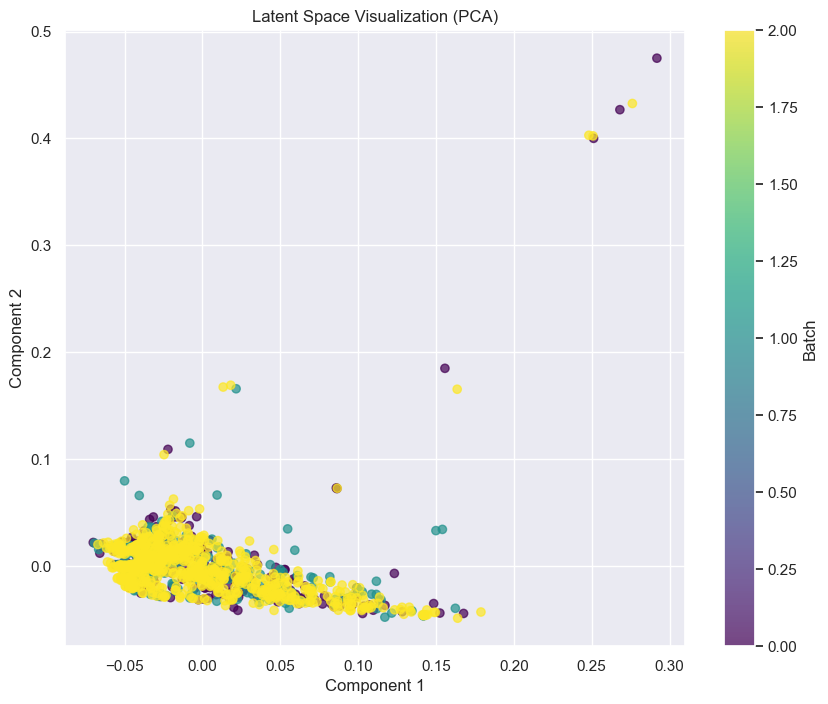

In [199]:
# Assuming `train_loader` is your DataLoader and `model` is your ProteinGraphVAE instance
plot_latent_space(model, train_loader, device, method='pca')

# sample from the latent space a few values


In [206]:
def sample_and_decode(model, num_samples=5, device='cpu'):
    """
    Sample random latent vectors and decode them to check for diversity in outputs.

    Args:
        model: Trained ProteinGraphVAE model.
        num_samples: Number of samples to generate.
        device: torch device.

    Returns:
        List of decoded node features.
    """
    model.eval()
    decoded_samples = []

    with torch.no_grad():
        for _ in range(num_samples):
            z = torch.randn(1, model.latent_channels, device=device)
            node_counts = torch.tensor([500], device=device)  # Adjust node count as needed
            edge_index = torch.zeros((2, 0), dtype=torch.long, device=device)  # Dummy edge_index
            node_features, edge_attr = model.decode(z, node_counts, edge_index)
            decoded_samples.append(node_features.cpu().numpy())

    return decoded_samples

# Example usage
decoded_samples = sample_and_decode(model, num_samples=5, device=device)
for i, sample in enumerate(decoded_samples):
    print(f"Sample {i+1}:")
    print(sample)

Sample 1:
[[[ 0.6455066   0.7022418   0.64117163 ...  1.2813094  -1.5910703
    0.5827952 ]
  [ 0.64597756  0.7028102   0.64161813 ...  1.2856431  -1.6025391
    0.5567047 ]
  [ 0.646275    0.7027421   0.64110106 ...  1.2845277  -1.5921603
    0.5613552 ]
  ...
  [ 0.64582974  0.7023525   0.6418175  ...  1.2799095  -1.610606
    0.5416784 ]
  [ 0.6459599   0.7029464   0.64123374 ...  1.2897863  -1.5802197
    0.58495575]
  [ 0.64582336  0.7024776   0.6413842  ...  1.2729926  -1.609981
    0.54660887]]]
Sample 2:
[[[ 0.6505905   0.689668    0.64410895 ...  1.3079541  -1.689609
    0.5572205 ]
  [ 0.65031224  0.69141495  0.64495313 ...  1.3195478  -1.6741358
    0.55160666]
  [ 0.6507601   0.69160783  0.64456064 ...  1.3095572  -1.6793162
    0.55629605]
  ...
  [ 0.6516342   0.69038093  0.64511645 ...  1.302763   -1.6504798
    0.5282913 ]
  [ 0.65023327  0.69132084  0.64511335 ...  1.3178608  -1.6837968
    0.5565307 ]
  [ 0.650708    0.69051254  0.6441425  ...  1.304806   -1.682615
  

In [220]:
# import torch
# import numpy as np
# from torch_geometric.data import Data
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# 
# def generate_protein_from_latent(model, num_nodes=200, device='cpu', temperature=0.8, norm_params=None):
#     """
#     Generate a new protein graph by sampling from the model's latent space with proper denormalization.
#     """
#     model.eval()
#     with torch.no_grad():
#         # Sample from latent space with adjusted temperature
#         z = torch.randn(1, model.latent_channels, device=device) * temperature
# 
#         # Create initial edge index for a more sparse graph
#         indices = torch.arange(num_nodes, device=device)
#         # Create edges only between nearby nodes in sequence
#         window_size = 10  # Maximum sequence distance for initial connections
#         rows = []
#         cols = []
#         for i in range(num_nodes):
#             for j in range(max(0, i-window_size), min(num_nodes, i+window_size)):
#                 if i != j:
#                     rows.extend([i, j])
#                     cols.extend([j, i])
# 
#         edge_index = torch.tensor([rows, cols], device=device)
# 
#         # Generate features and edge attributes using the decoder
#         features, edge_attr = model.decode(z, num_nodes, edge_index)
#         features = features.squeeze(0)  # Remove batch dimension
# 
#         # Denormalize features if normalization parameters are provided
#         if norm_params:
#             # Mass
#             features[:, 0] = features[:, 0] * norm_params['mass'][1] + norm_params['mass'][0]
#             # Force masses to be close to valid amino acid masses
#             masses = features[:, 0].cpu().numpy()
#             for i, mass in enumerate(masses):
#                 closest_aa = min(AMINO_ACID_DATA, key=lambda x: abs(x[0] - mass))
#                 features[i, 0] = torch.tensor(closest_aa[0])
# 
#             # Distances
#             features[:, 1:3] = features[:, 1:3] * norm_params['dist'][1] + norm_params['dist'][0]
#             # Ensure CA-CA distances are realistic (3.7-4.0 Å)
#             features[:, 1] = torch.clamp(features[:, 1], min=3.7, max=4.0)
#             # Ensure CB-CB distances are realistic (4.5-6.5 Å)
#             features[:, 2] = torch.clamp(features[:, 2], min=4.5, max=6.5)
# 
#             # Coordination numbers
#             features[:, 3] = features[:, 3] * norm_params['count'][1] + norm_params['count'][0]
#             features[:, 3] = torch.clamp(features[:, 3], min=2, max=12)
# 
#             # Small molecule interaction scores
#             features[:, 4] = torch.sigmoid(features[:, 4])
# 
#             # Coordinates
#             features[:, 5:] = features[:, 5:] * norm_params['coords'][1] + norm_params['coords'][0]
# 
#         # Apply sigmoid to edge attributes and filter
#         edge_probs = torch.sigmoid(edge_attr)
#         valid_edges = edge_probs.squeeze() > 0.5
#         filtered_edge_index = edge_index[:, valid_edges]
#         filtered_edge_attr = edge_attr[valid_edges]
# 
#         # Ensure the graph is connected
#         component_edges = ensure_connected_graph(filtered_edge_index, num_nodes)
#         if component_edges is not None:
#             filtered_edge_index = component_edges
#             filtered_edge_attr = torch.ones(component_edges.size(1), 1, device=device)
# 
#         # Create PyG Data object
#         data = Data(
#             x=features,
#             edge_index=filtered_edge_index,
#             edge_attr=filtered_edge_attr,
#             num_nodes=num_nodes
#         )
# 
#         return data
# 
def plot_protein_graph_3d(data, show_edges=True, figsize=(12, 12)):
    """
    Plot the protein graph in 3D space with amino acid-colored nodes.
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Extract coordinates from the last 3 features
    coords = data.x[:, -3:].detach().cpu().numpy()

    # Color nodes by mass (first feature)
    masses = data.x[:, 0].detach().cpu().numpy()
    node_colors = [map_mass_to_color(float(mass)) for mass in masses]

    # Plot nodes
    scatter = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                         c=node_colors, s=100, alpha=0.8)

    # Plot edges if requested and if they exist
    if show_edges and hasattr(data, 'edge_index'):
        edges = data.edge_index.t().detach().cpu().numpy()
        edge_attrs = data.edge_attr.detach().cpu().numpy() if hasattr(data, 'edge_attr') else None

        for i, edge in enumerate(edges):
            start = coords[edge[0]]
            end = coords[edge[1]]

            # Use edge attributes for line width if available
            width = 1.0 if edge_attrs is None else float(edge_attrs[i])
            alpha = min(1.0, width)

            ax.plot([start[0], end[0]],
                    [start[1], end[1]],
                    [start[2], end[2]],
                    color='gray', alpha=min(0.3, alpha), linewidth=width)

    # Add legend for amino acids
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor=color, label=name, markersize=10)
                       for mass, name, color in AMINO_ACID_DATA]
    ax.legend(handles=legend_elements, loc='center left',
              bbox_to_anchor=(1, 0.5), title="Amino Acids")

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Generated Protein Structure')

    plt.tight_layout()
    plt.show()

# def ensure_connected_graph(edge_index, num_nodes):
#     """
#     Ensure the graph is connected by adding minimum spanning tree edges if needed.
#     """
#     import networkx as nx
#     from torch_geometric.utils import to_networkx
# 
#     # Create NetworkX graph from edge_index
#     edges = edge_index.t().cpu().numpy()
#     G = nx.Graph()
#     G.add_nodes_from(range(num_nodes))
#     G.add_edges_from(edges)
# 
#     # If graph is not connected, add minimum spanning tree edges
#     if not nx.is_connected(G):
#         # Create a complete graph for finding MST
#         complete_G = nx.complete_graph(num_nodes)
#         # Find MST
#         mst = nx.minimum_spanning_tree(complete_G)
#         # Add MST edges to original graph
#         G.add_edges_from(mst.edges())
# 
#     # Convert back to edge_index format
#     edges = list(G.edges())
#     if not edges:
#         return None
#     edge_index = torch.tensor([[e[0] for e in edges] + [e[1] for e in edges],
#                                [e[1] for e in edges] + [e[0] for e in edges]])
#     return edge_index
# 
# # Example normalization parameters (you should use the actual values from your training data)
# default_norm_params = {
#     'mass': (130.0, 30.0),  # mean, std
#     'dist': (4.0, 1.0),
#     'count': (6.0, 2.0),
#     'coords': (0.0, 5.0)
# }
# 
# 

def print_node_features(data, num_nodes=10):
     """
     Print detailed features for the first n nodes.
     """
     print("\nNode Features:")
     print("Index | Amino Acid (Mass) | Distances (CA-CA, CB-CB) | Coord | SmallMol | Coordinates (x, y, z)")
     print("-" * 90)
 
     features = data.x[:num_nodes]
     for i, feat in enumerate(features):
         mass = feat[0].item()
         closest_aa = min(AMINO_ACID_DATA, key=lambda x: abs(x[0] - mass))
         aa_name = closest_aa[1]
 
         print(f"{i:5d} | {aa_name:<15} ({mass:6.2f}) | "
               f"({feat[1]:5.2f}, {feat[2]:5.2f}) | "
               f"{feat[3]:5.2f} | "
               f"{feat[4]:8.3f} | "
               f"({feat[5]:6.2f}, {feat[6]:6.2f}, {feat[7]:6.2f})")
# 
# # Usage example:
# def generate_and_analyze_protein(model, num_nodes=200, norm_params=default_norm_params):
#     """
#     Generate and analyze a protein structure with proper normalization.
#     """
#     # Generate structure
#     data = generate_protein_from_latent(model, num_nodes=num_nodes, norm_params=norm_params)
# 
#     # Print features
#     print_node_features(data, num_nodes=10)
# 
#     # Plot structure
#     plot_protein_graph_3d(data)
# 
#     return data

In [222]:
import random

def test_untrained_model(model, num_nodes=10):
    """
    Test an untrained VAE model's generation capabilities with proper edge construction.
    """
    print("Testing untrained model with random latent vector...")

    # Create test edge index - now with proper node relationships
    edge_list = []
    for i in range(num_nodes):
        # Connect to previous and next node (backbone-like connections)
        if i > 0:
            edge_list.extend([[i-1, i], [i, i-1]])
        # Add some random longer-range connections
        for _ in range(2):  # Add 2 random connections per node
            j = random.randint(0, num_nodes-1)
            if j != i:
                edge_list.extend([[i, j], [j, i]])

    edge_index = torch.tensor(edge_list).t()

    # Sample multiple latent vectors to encourage diversity
    z = torch.randn(1, model.latent_channels) * 2.0  # Increased variance
    print("\nLatent vector stats:")
    print(f"Mean: {z.mean():.3f}, Std: {z.std():.3f}")
    print("Sample values:", z[0, :5].tolist())

    # Generate features
    with torch.no_grad():
        features, edge_attr = model.decode(z, num_nodes, edge_index)

    print("\nRaw decoder output stats:")
    features = features.squeeze(0)  # Remove batch dimension
    for i in range(features.size(1)):
        print(f"Feature {i}: mean={features[:, i].mean():.3f}, std={features[:, i].std():.3f}")

    # Create PyG Data object
    data = Data(
        x=features,
        edge_index=edge_index,
        edge_attr=edge_attr,
        num_nodes=num_nodes
    )

    return data

def generate_and_analyze_protein(model, num_nodes=200):
    """
    Generate and analyze a protein structure with multiple latent vectors for diversity.
    """
    # Generate multiple structures and combine them
    num_segments = 4
    nodes_per_segment = num_nodes // num_segments

    all_data = []
    for i in range(num_segments):
        # Generate segment with different latent vector
        segment_data = test_untrained_model(model, nodes_per_segment)
        all_data.append(segment_data)

    # Combine segments (simplified version)
    combined_features = torch.cat([d.x for d in all_data], dim=0)

    # Create new edge index for combined structure
    edge_list = []
    offset = 0
    for data in all_data:
        # Add original edges with offset
        edges = data.edge_index.t().tolist()
        for edge in edges:
            edge_list.append([edge[0] + offset, edge[1] + offset])

        # Connect to next segment if not last
        if offset < (len(all_data) - 1) * nodes_per_segment:
            edge_list.append([offset + nodes_per_segment - 1, offset + nodes_per_segment])
            edge_list.append([offset + nodes_per_segment, offset + nodes_per_segment - 1])

        offset += nodes_per_segment

    combined_edge_index = torch.tensor(edge_list).t()

    # Create combined edge attributes
    combined_edge_attr = torch.rand(combined_edge_index.size(1), 1)

    # Create final combined data object
    combined_data = Data(
        x=combined_features,
        edge_index=combined_edge_index,
        edge_attr=combined_edge_attr,
        num_nodes=num_nodes
    )

    # Print features
    print_node_features(combined_data, num_nodes=10)

    return combined_data

# Test the model
test_data = test_untrained_model(model)
print("\nSample node features:")
print_node_features(test_data, num_nodes=5)

Testing untrained model with random latent vector...

Latent vector stats:
Mean: 1.341, Std: 1.627
Sample values: [0.42082372307777405, 4.92212438583374, -0.8080372214317322, 0.15116408467292786, 0.7926412224769592]

Raw decoder output stats:
Feature 0: mean=0.025, std=0.022
Feature 1: mean=0.014, std=0.011
Feature 2: mean=0.018, std=0.016
Feature 3: mean=0.053, std=0.054
Feature 4: mean=-2.235, std=0.340
Feature 5: mean=-0.107, std=0.224
Feature 6: mean=-0.042, std=0.194
Feature 7: mean=-0.019, std=0.239

Sample node features:

Node Features:
Index | Amino Acid (Mass) | Distances (CA-CA, CB-CB) | Coord | SmallMol | Coordinates (x, y, z)
------------------------------------------------------------------------------------------
    0 | Glycine         (  0.06) | ( 0.03,  0.04) |  0.06 |   -1.999 | (  0.38,   0.07,  -0.17)
    1 | Glycine         (  0.01) | ( 0.00,  0.01) |  0.02 |   -2.590 | ( -0.05,   0.11,   0.10)
    2 | Glycine         (  0.04) | ( 0.02,  0.03) |  0.08 |   -1.895 | 

In [223]:
# Initialize model with new architecture
model = ProteinGraphVAE(
    in_channels=8,
    hidden_channels=64,
    latent_channels=16,
    num_heads=4,
    edge_dim=1
)

# Test untrained model
test_data = test_untrained_model(model)
print("\nSample node features:")
print_node_features(test_data, num_nodes=5)

Testing untrained model with random latent vector...

Latent vector stats:
Mean: 0.436, Std: 1.539
Sample values: [0.9699660539627075, 0.8996179699897766, 2.7348673343658447, -1.5437849760055542, 0.6162249445915222]

Raw decoder output stats:
Feature 0: mean=0.730, std=0.055
Feature 1: mean=0.703, std=0.070
Feature 2: mean=0.758, std=0.072
Feature 3: mean=0.665, std=0.073
Feature 4: mean=0.228, std=0.164
Feature 5: mean=0.296, std=0.838
Feature 6: mean=-1.812, std=1.068
Feature 7: mean=0.013, std=1.029

Sample node features:

Node Features:
Index | Amino Acid (Mass) | Distances (CA-CA, CB-CB) | Coord | SmallMol | Coordinates (x, y, z)
------------------------------------------------------------------------------------------
    0 | Glycine         (  0.72) | ( 0.67,  0.78) |  0.55 |    0.037 | (  0.35,  -2.61,   1.41)
    1 | Glycine         (  0.66) | ( 0.63,  0.64) |  0.71 |    0.255 | ( -1.45,  -4.07,  -0.42)
    2 | Glycine         (  0.80) | ( 0.75,  0.71) |  0.64 |   -0.068 | (  

In [224]:
# Get normalization parameters from your training data
# norm_params = get_normalization_params(train_loader)  # You would need to implement this

# Or use default parameters for testing
generated_graph = generate_and_analyze_protein(model, num_nodes=200)

Testing untrained model with random latent vector...

Latent vector stats:
Mean: -0.246, Std: 1.273
Sample values: [-1.9430991411209106, 0.9554151892662048, -1.3689908981323242, -1.0787343978881836, -2.544485569000244]

Raw decoder output stats:
Feature 0: mean=0.746, std=0.057
Feature 1: mean=0.721, std=0.058
Feature 2: mean=0.756, std=0.060
Feature 3: mean=0.685, std=0.053
Feature 4: mean=0.198, std=0.157
Feature 5: mean=0.196, std=0.902
Feature 6: mean=-1.975, std=1.243
Feature 7: mean=-0.197, std=1.457
Testing untrained model with random latent vector...

Latent vector stats:
Mean: 0.902, Std: 1.589
Sample values: [-1.278265357017517, 1.6081761121749878, 1.0172441005706787, 2.861433267593384, -0.3918567895889282]

Raw decoder output stats:
Feature 0: mean=0.733, std=0.052
Feature 1: mean=0.718, std=0.060
Feature 2: mean=0.759, std=0.057
Feature 3: mean=0.683, std=0.050
Feature 4: mean=0.199, std=0.113
Feature 5: mean=0.250, std=0.913
Feature 6: mean=-1.879, std=1.254
Feature 7: mea

Original mass: 0.7007224559783936, Scaled mass: 34.01444911956787
Original mass: 0.6601091027259827, Scaled mass: 33.20218205451965
Original mass: 0.796453595161438, Scaled mass: 35.92907190322876
Original mass: 0.7295083999633789, Scaled mass: 34.59016799926758
Original mass: 0.7258433103561401, Scaled mass: 34.5168662071228
Original mass: 0.6453580856323242, Scaled mass: 32.907161712646484
Original mass: 0.7511587738990784, Scaled mass: 35.02317547798157
Original mass: 0.7784451842308044, Scaled mass: 35.56890368461609
Original mass: 0.7203049063682556, Scaled mass: 34.40609812736511
Original mass: 0.6631858944892883, Scaled mass: 33.26371788978577
Original mass: 0.7097999453544617, Scaled mass: 34.19599890708923
Original mass: 0.69633948802948, Scaled mass: 33.9267897605896
Original mass: 0.6593482494354248, Scaled mass: 33.186964988708496
Original mass: 0.721724808216095, Scaled mass: 34.4344961643219
Original mass: 0.8079925179481506, Scaled mass: 36.15985035896301
Original mass: 

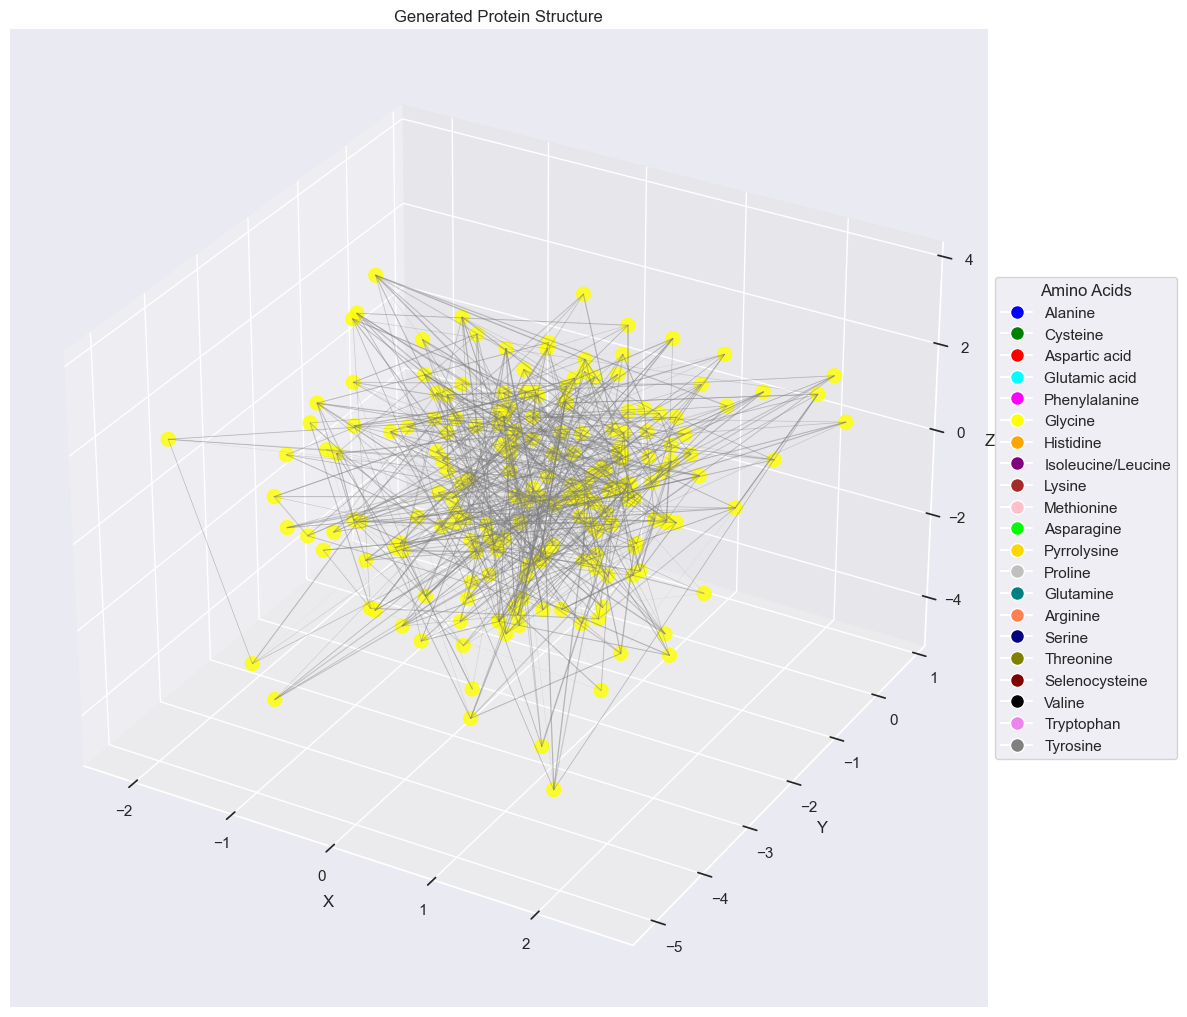

In [228]:
plot_protein_graph_3d(generated_graph)

/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



Dataset prepared:
Number of training graphs: 1308
Number of test graphs: 328
Number of features per node: 8

Normalization statistics:
Mass - mean: -0.0000, std: 1.0000
Distances - mean: -0.0000, std: 1.0000
Count - mean: 0.0000, std: 1.0000
Coordinates - mean: 0.0000, std: 1.0000
Starting training for 1 epochs...
Training on device: cpu
Number of training batches: 82
Number of validation batches: 21
KL annealing: 1e-05 -> 0.005 over 25 epochs
Orthogonal regularization strength: 0.1


Epoch 1/1 [Train]:   0%|          | 0/82 [00:00<?, ?it/s]


Batch shapes:
Input x shape: torch.Size([10696, 8])
Edge index shape: torch.Size([2, 42784])
Edge attr shape: torch.Size([42784, 1])
Reconstruction shape: torch.Size([16, 1827, 8])
Edge reconstruction shape: torch.Size([42784, 1])

Detailed loss diagnostics:
Raw recon_loss: 0.6537
Raw KL loss: 0.4295
Ortho loss: 1.4978
Current beta: 0.0000
mu mean: 0.0237, std: 0.1136
logvar mean: 1.0503, std: 0.1611
mass: 0.1481
distance: 0.1438
count: 0.0695
small_mol: 0.0561
coord: 0.1516
edge: 0.0847


Epoch 1/1 [Train]:  12%|█▏        | 10/82 [00:12<01:23,  1.16s/it, loss=1.9522, recon=0.5184, kl=0.4236, ortho=1.4338]


Detailed loss diagnostics:
Raw recon_loss: 0.5476
Raw KL loss: 0.4342
Ortho loss: 1.4349
Current beta: 0.0000
mu mean: 0.0018, std: 0.1355
logvar mean: 1.0496, std: 0.1696
mass: 0.1431
distance: 0.1310
count: 0.0642
small_mol: 0.0554
coord: 0.0777
edge: 0.0761


Epoch 1/1 [Train]:  24%|██▍       | 20/82 [00:23<01:22,  1.34s/it, loss=2.0427, recon=0.6104, kl=0.4357, ortho=1.4323]


Detailed loss diagnostics:
Raw recon_loss: 0.5471
Raw KL loss: 0.4412
Ortho loss: 1.4347
Current beta: 0.0000
mu mean: -0.0081, std: 0.1514
logvar mean: 1.0488, std: 0.1901
mass: 0.1553
distance: 0.1502
count: 0.0629
small_mol: 0.0528
coord: 0.0537
edge: 0.0721


Epoch 1/1 [Train]:  37%|███▋      | 30/82 [00:36<01:17,  1.48s/it, loss=1.8314, recon=0.4039, kl=0.4307, ortho=1.4275]


Detailed loss diagnostics:
Raw recon_loss: 0.4602
Raw KL loss: 0.4413
Ortho loss: 1.4274
Current beta: 0.0000
mu mean: -0.0183, std: 0.1667
logvar mean: 1.0417, std: 0.2055
mass: 0.1221
distance: 0.1162
count: 0.0552
small_mol: 0.0424
coord: 0.0541
edge: 0.0703


Epoch 1/1 [Train]:  49%|████▉     | 40/82 [00:46<00:38,  1.08it/s, loss=1.8432, recon=0.4160, kl=0.4276, ortho=1.4272]


Detailed loss diagnostics:
Raw recon_loss: 0.4119
Raw KL loss: 0.4426
Ortho loss: 1.4243
Current beta: 0.0000
mu mean: -0.0189, std: 0.1888
logvar mean: 1.0323, std: 0.2257
mass: 0.1065
distance: 0.0972
count: 0.0490
small_mol: 0.0457
coord: 0.0442
edge: 0.0692


Epoch 1/1 [Train]:  61%|██████    | 50/82 [00:58<00:46,  1.44s/it, loss=1.8857, recon=0.4600, kl=0.4389, ortho=1.4257]


Detailed loss diagnostics:
Raw recon_loss: 0.3540
Raw KL loss: 0.4421
Ortho loss: 1.4258
Current beta: 0.0000
mu mean: -0.0101, std: 0.1850
logvar mean: 1.0287, std: 0.2356
mass: 0.0981
distance: 0.0896
count: 0.0448
small_mol: 0.0311
coord: 0.0232
edge: 0.0672


Epoch 1/1 [Train]:  73%|███████▎  | 60/82 [01:11<00:32,  1.48s/it, loss=1.7701, recon=0.3469, kl=0.4598, ortho=1.4232]


Detailed loss diagnostics:
Raw recon_loss: 0.3743
Raw KL loss: 0.4781
Ortho loss: 1.4232
Current beta: 0.0000
mu mean: -0.0137, std: 0.2701
logvar mean: 1.0252, std: 0.2882
mass: 0.0946
distance: 0.0970
count: 0.0529
small_mol: 0.0239
coord: 0.0365
edge: 0.0695


Epoch 1/1 [Train]:  85%|████████▌ | 70/82 [01:21<00:10,  1.15it/s, loss=1.7958, recon=0.3739, kl=0.4589, ortho=1.4219]


Detailed loss diagnostics:
Raw recon_loss: 0.5924
Raw KL loss: 0.4613
Ortho loss: 1.4217
Current beta: 0.0000
mu mean: -0.0032, std: 0.2308
logvar mean: 1.0261, std: 0.2734
mass: 0.0995
distance: 0.1318
count: 0.2208
small_mol: 0.0303
coord: 0.0366
edge: 0.0734


Epoch 1/1 [Train]:  98%|█████████▊| 80/82 [01:32<00:01,  1.04it/s, loss=1.7907, recon=0.3683, kl=0.4417, ortho=1.4224]


Detailed loss diagnostics:
Raw recon_loss: 0.2912
Raw KL loss: 0.4111
Ortho loss: 1.4213
Current beta: 0.0000
mu mean: -0.0236, std: 0.1508
logvar mean: 1.0207, std: 0.1786
mass: 0.0748
distance: 0.0707
count: 0.0319
small_mol: 0.0216
coord: 0.0263
edge: 0.0660


Epoch 1/1 [Train]: 100%|██████████| 82/82 [01:36<00:00,  1.18s/it, loss=1.7797, recon=0.3432, kl=0.4192, ortho=1.4365]



Starting validation...


Epoch 1/1 [Valid]: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]



Epoch [1/1] - Time: 104.22s
Train - Total: 1.8990, Recon: 0.4676, KL: 0.4460, Ortho: 1.4314, Beta: 0.0000
Feature Losses:
  mass_loss: 0.1175
  distance_loss: 0.1125
  count_loss: 0.0643
  small_mol_loss: 0.0425
  coord_loss: 0.0595
  edge_loss: 0.0714


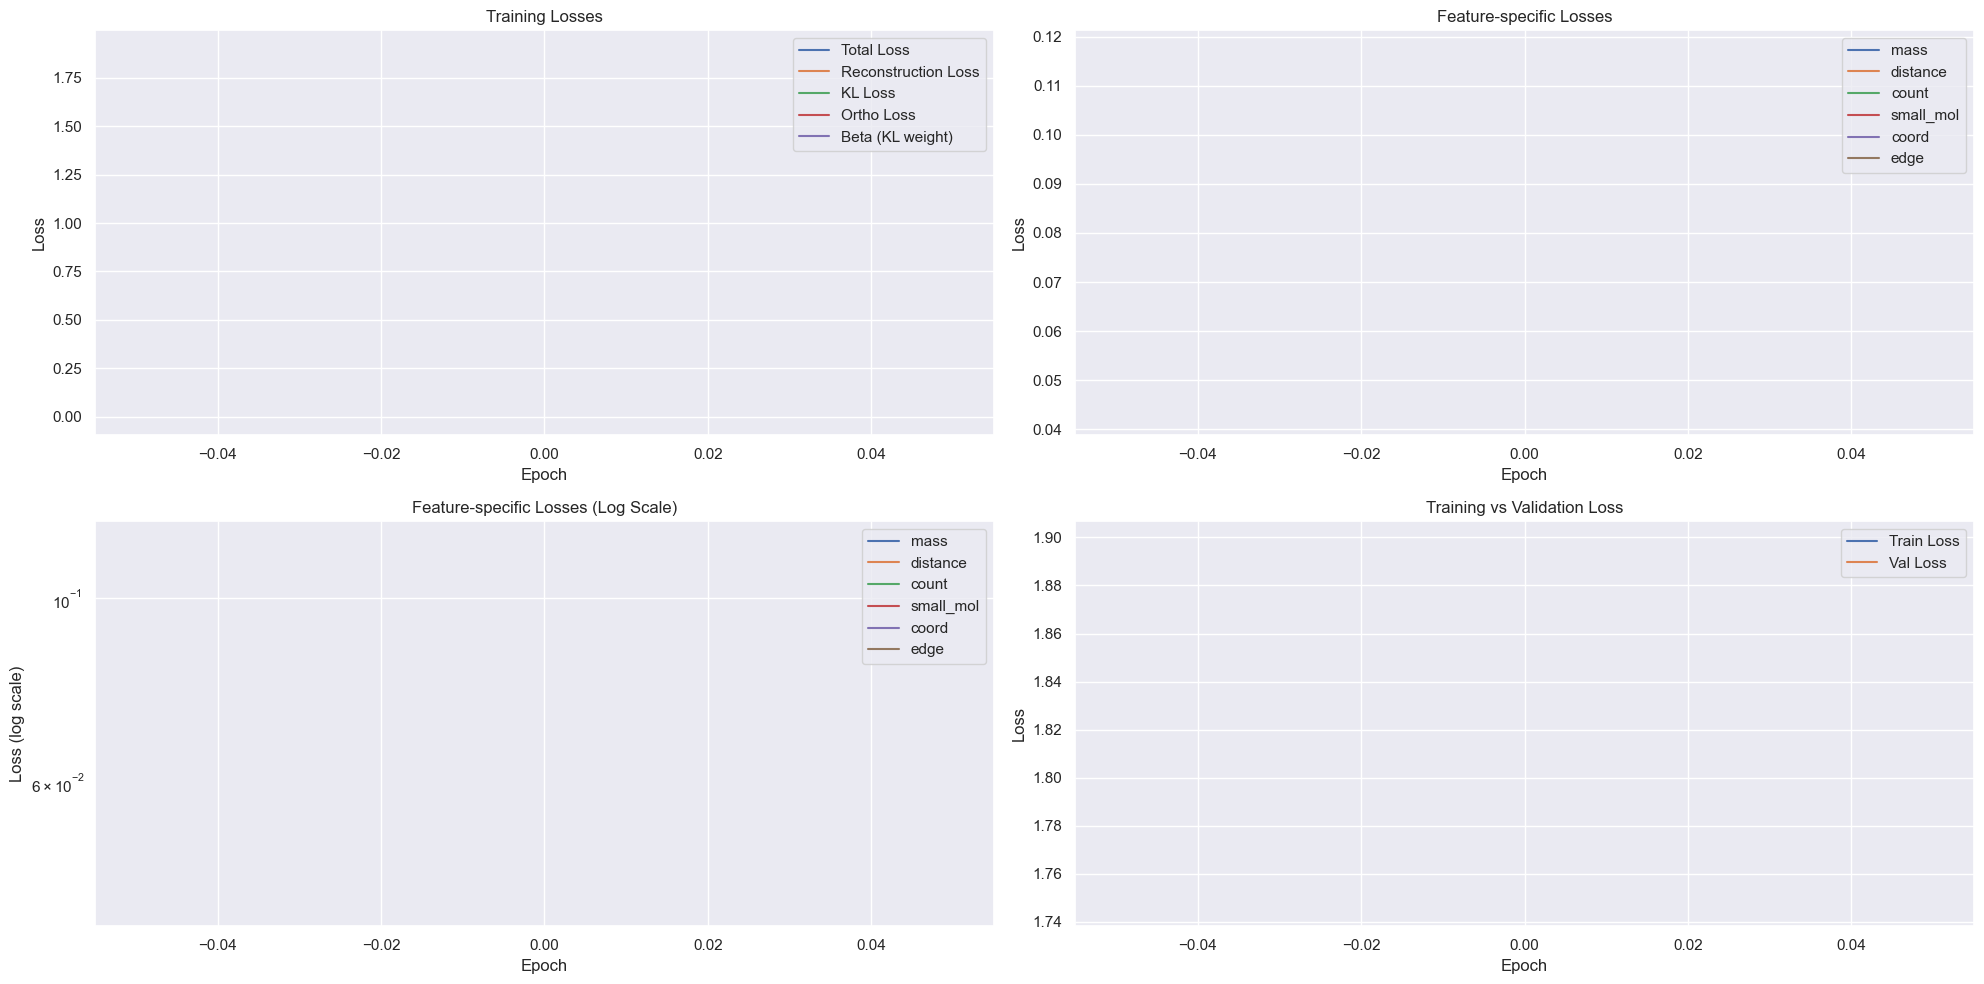


Training completed!


In [229]:
# Adjust batch size for better gradient estimates
train_loader, test_loader, in_channels, norm_params = prepare_graphs_for_vae(
    graphs,
    batch_size=16,  # Increased batch size
    train_ratio=0.8,
    shuffle=True
)

# Update model parameters
model = ProteinGraphVAE(
    in_channels=8,
    hidden_channels=64,
    latent_channels=16,
    num_heads=4,
    edge_dim=1
).to(device)



# Adjust learning rate schedule
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Update loss weights in the model to focus on underperforming features
model.loss_weights = {
    'mass': 0.1,
    'distance': 0.1,
    'count': 0.05,     # Lara: Updated, old=0.2 ; Increased to improve count prediction
    'small_mol': 0.1,
    'coord': 0.1,
    'edge': 0.2       # Increased to improve edge reconstruction
}

# Train with slightly different parameters
num_epochs = 10
model, history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    num_epochs=1,
    min_beta=0.00001,    # Lower starting point
    max_beta=0.005,      # Slightly lower max
    warmup_epochs=25,    # Longer warmup
    lambda_ortho=0.1     # Keep orthogonal regularization as is
)

In [230]:
import torch

# Assuming `model` is your trained ProteinGraphVAE instance
model_path = 'protein_graph_vae.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to protein_graph_vae.pth


# Latent space

In [231]:
def visualize_latent_space(model, data_loader, device='cuda', method='tsne', perplexity=30):
    """
    Visualize the latent space using t-SNE or PCA.

    Parameters:
    - model: Trained ProteinGraphVAE model.
    - data_loader: PyTorch Geometric DataLoader containing graphs.
    - device: 'cuda' or 'cpu'.
    - method: 'tsne' or 'pca' for dimensionality reduction.
    - perplexity: t-SNE perplexity (only for t-SNE).

    Returns:
    - None (displays the plot).
    """
    model.eval()
    model = model.to(device)
    
    latent_vectors = []
    graph_labels = []  # Collect one label per graph

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            
            # Encode to latent space
            mu, _ = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            
            if mu.size(0) == batch.batch.max().item() + 1:
                # mu is already graph-level
                latent_vectors.append(mu.cpu().numpy())
                graph_labels.extend(range(mu.size(0)))
            else:
                # mu is node-level, pool to graph-level
                pooled_mu = global_mean_pool(mu, batch.batch)  # Shape: [num_graphs, latent_dim]
                latent_vectors.append(pooled_mu.cpu().numpy())
                graph_labels.extend(batch.batch.unique().cpu().numpy())  # Graph-level labels
    
    # Concatenate results
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    graph_labels = np.array(graph_labels[:len(latent_vectors)])  # Ensure labels match latent vectors

    # Dimensionality reduction
    if method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'.")
    
    reduced_latent = reducer.fit_transform(latent_vectors)

    # Plotting
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(
        reduced_latent[:, 0],
        reduced_latent[:, 1],
        c=graph_labels[:reduced_latent.shape[0]],  # Use graph-level labels
        cmap='viridis',
        alpha=0.7
    )
    plt.colorbar(scatter, label='Graph Labels')
    plt.title(f'Latent Space Visualization ({method.upper()})')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()



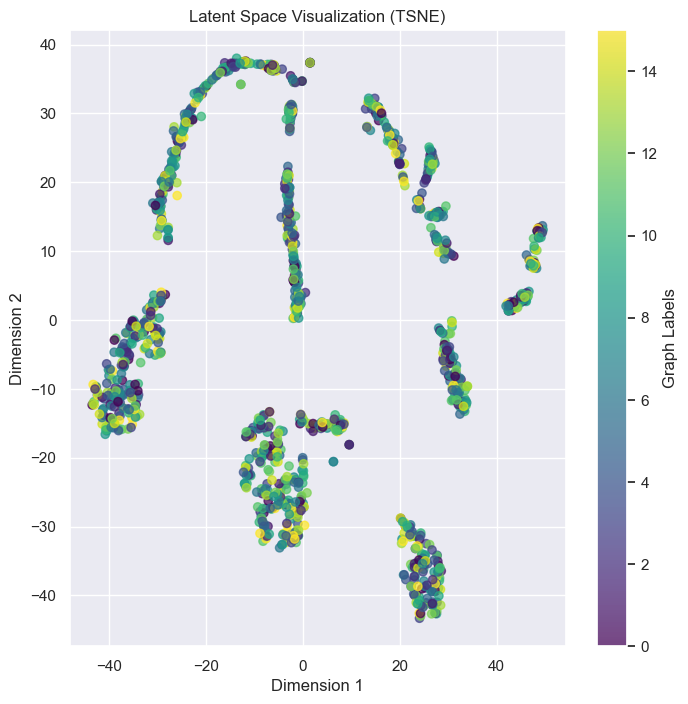

In [232]:
visualize_latent_space(model, train_loader, device=device, method='tsne', perplexity=30)

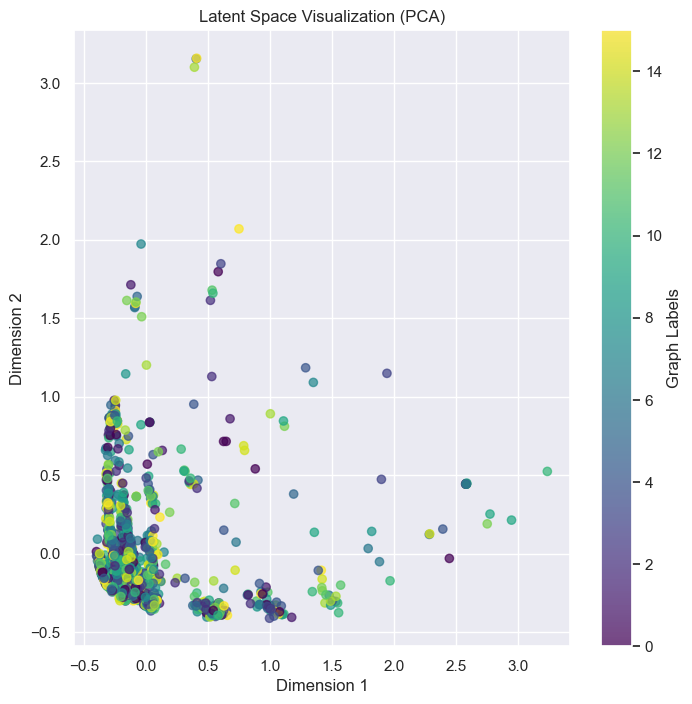

In [233]:
visualize_latent_space(model, train_loader, device=device, method='pca')

latent space analysis of correlation etc

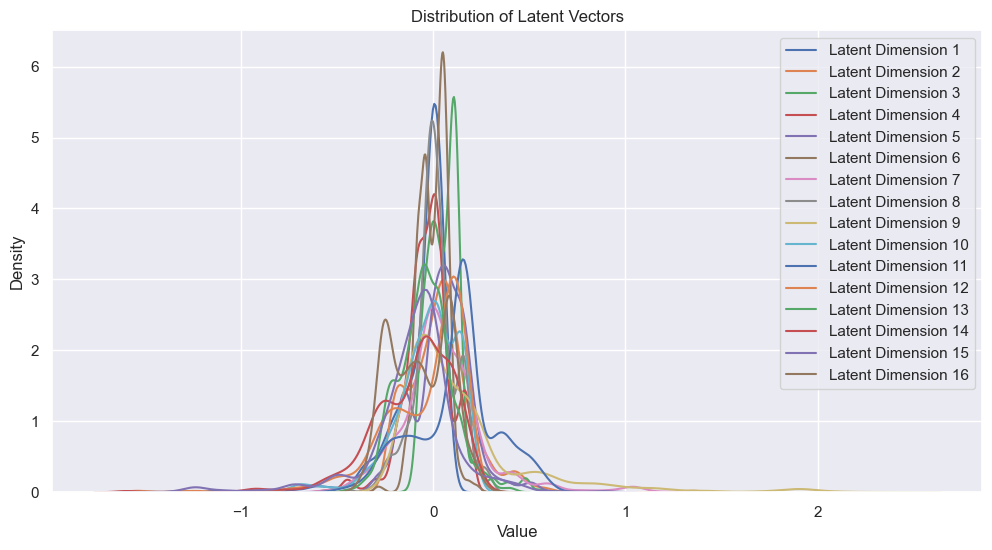

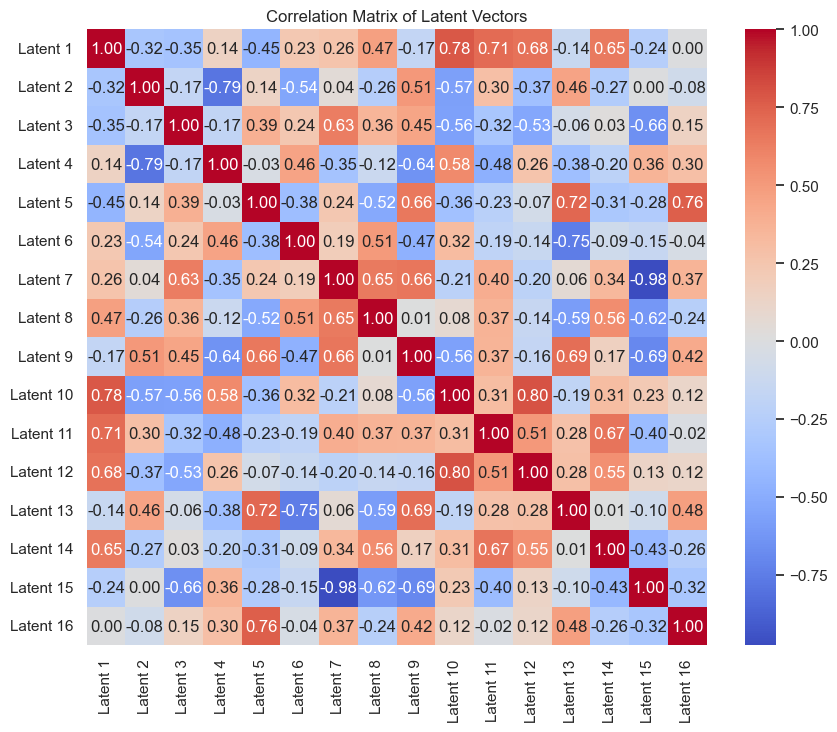

In [234]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_latent_distribution_and_correlation(model, data_loader, device):
    """
    Plot the distribution of latent vectors and the correlation matrix.

    Args:
        model: Trained ProteinGraphVAE model.
        data_loader: DataLoader containing the data.
        device: torch device.
    """
    model.eval()
    latent_vectors = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)

    # Plot the distribution of latent vectors
    plt.figure(figsize=(12, 6))
    for i in range(latent_vectors.shape[1]):
        sns.kdeplot(latent_vectors[:, i], label=f'Latent Dimension {i+1}')
    plt.title('Distribution of Latent Vectors')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Compute and plot the correlation matrix
    correlation_matrix = np.corrcoef(latent_vectors, rowvar=False)
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
                xticklabels=[f'Latent {i+1}' for i in range(latent_vectors.shape[1])],
                yticklabels=[f'Latent {i+1}' for i in range(latent_vectors.shape[1])])
    plt.title('Correlation Matrix of Latent Vectors')
    plt.show()

# Example usage
plot_latent_distribution_and_correlation(model, train_loader, device)

In [235]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import wasserstein_distance

def analyze_latent_space(model, data_loader, device, save_path=None):
    """
    Analyze and visualize the latent space distributions and correlations
    
    Args:
        model: Trained ProteinGraphVAE model
        data_loader: DataLoader containing protein graphs
        device: torch device
        save_path: Optional path to save visualizations
    """
    model.eval()
    latent_vectors = []

    # Collect latent vectors
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            latent_vectors.append(mu.cpu().numpy())

    # Concatenate all latent vectors
    latent_vectors = np.concatenate(latent_vectors, axis=0)

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 10))

    # 1. Distribution plots for each latent dimension
    ax1 = plt.subplot(231)
    for i in range(latent_vectors.shape[1]):
        sns.kdeplot(data=latent_vectors[:, i], ax=ax1, label=f'Dim {i}')
    ax1.set_title('Latent Dimension Distributions')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Density')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 2. Correlation matrix
    ax2 = plt.subplot(232)
    corr_matrix = np.corrcoef(latent_vectors.T)
    sns.heatmap(corr_matrix,
                ax=ax2,
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True,
                xticklabels=False,
                yticklabels=False)
    ax2.set_title('Latent Dimension Correlations')

    # 3. PCA visualization
    ax3 = plt.subplot(233)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(latent_vectors)
    scatter = ax3.scatter(pca_result[:, 0],
                          pca_result[:, 1],
                          alpha=0.5,
                          c=np.sum(latent_vectors**2, axis=1),  # Color by L2 norm
                          cmap='viridis')
    plt.colorbar(scatter, ax=ax3, label='L2 Norm')
    ax3.set_title(f'PCA Projection\nExplained Variance: {pca.explained_variance_ratio_.sum():.2%}')

    # 4. Box plot of latent dimensions
    ax4 = plt.subplot(234)
    ax4.boxplot(latent_vectors)
    ax4.set_title('Latent Dimension Ranges')
    ax4.set_xlabel('Dimension')
    ax4.set_ylabel('Value')

    # 5. Dimension-wise statistics
    ax5 = plt.subplot(235)
    stats = pd.DataFrame({
        'Mean': np.mean(latent_vectors, axis=0),
        'Std': np.std(latent_vectors, axis=0),
        'Median': np.median(latent_vectors, axis=0),
        'IQR': np.percentile(latent_vectors, 75, axis=0) - np.percentile(latent_vectors, 25, axis=0)
    })
    stats.index = [f'Dim {i}' for i in range(latent_vectors.shape[1])]
    sns.heatmap(stats,
                ax=ax5,
                cmap='viridis',
                annot=True,
                fmt='.2f')
    ax5.set_title('Dimension-wise Statistics')

    # 6. Wasserstein distance matrix between dimensions
    ax6 = plt.subplot(236)
    n_dims = latent_vectors.shape[1]
    wasserstein_mat = np.zeros((n_dims, n_dims))
    for i in range(n_dims):
        for j in range(n_dims):
            wasserstein_mat[i, j] = wasserstein_distance(
                latent_vectors[:, i],
                latent_vectors[:, j]
            )
    sns.heatmap(wasserstein_mat,
                ax=ax6,
                cmap='viridis',
                square=True,
                xticklabels=False,
                yticklabels=False)
    ax6.set_title('Wasserstein Distances\nbetween Dimensions')

    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # Calculate additional metrics
    metrics = {
        'mean_correlation': np.mean(np.abs(corr_matrix - np.eye(n_dims))),
        'max_correlation': np.max(np.abs(corr_matrix - np.eye(n_dims))),
        'mean_wasserstein': np.mean(wasserstein_mat),
        'dimension_entropy': -np.sum(np.mean(latent_vectors, axis=0) * np.log(np.abs(np.mean(latent_vectors, axis=0)) + 1e-10)),
        'pca_explained_variance': pca.explained_variance_ratio_.sum()
    }

    return fig, metrics

def visualize_latent_traversal(model, data_loader, device, dim_idx=0, n_steps=10):
    """
    Visualize how changing a single latent dimension affects the reconstruction
    
    Args:
        model: Trained ProteinGraphVAE model
        data_loader: DataLoader containing protein graphs
        device: torch device
        dim_idx: Index of dimension to traverse
        n_steps: Number of steps in traversal
    """
    model.eval()

    # Get a sample batch
    batch = next(iter(data_loader)).to(device)

    # Get latent representation
    with torch.no_grad():
        mu, logvar = model.encode(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        z = model.reparameterize(mu, logvar)

    # Create traversal values
    traversal_range = np.linspace(-3, 3, n_steps)
    reconstructions = []

    # Generate reconstructions
    with torch.no_grad():
        for value in traversal_range:
            z_new = z.clone()
            z_new[:, dim_idx] = value
            recon, edge_recon = model.decode(z_new, batch.x.size(0), batch.edge_index)
            reconstructions.append(recon.cpu().numpy())

    return np.array(reconstructions), traversal_range

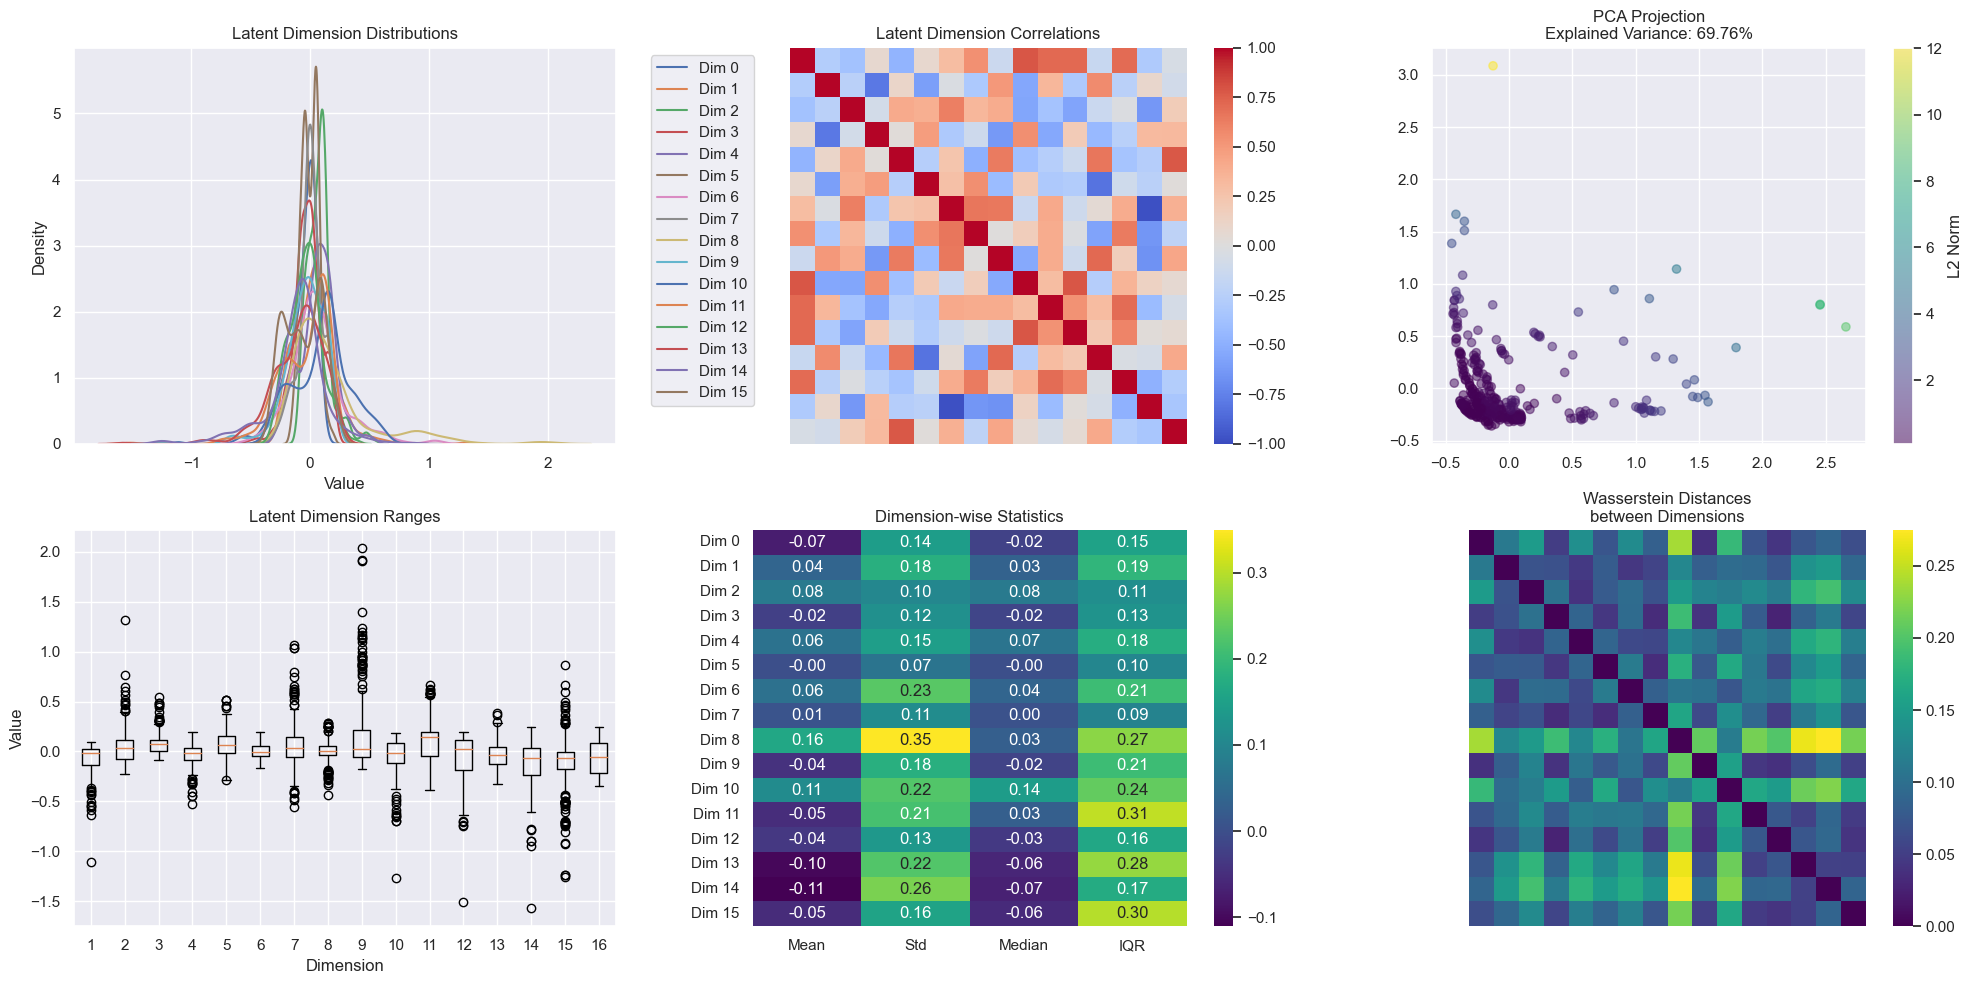

mean_correlation: 0.3362
max_correlation: 0.9777
mean_wasserstein: 0.1011
dimension_entropy: -0.0873
pca_explained_variance: 0.6976


In [236]:
# After training your model
fig, metrics = analyze_latent_space(model, test_loader, device)
plt.show()

# Print latent space metrics
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

# Visualize how changing dimension 0 affects reconstruction
reconstructions, traversal_values = visualize_latent_traversal(model, test_loader, device, dim_idx=0)

# Generator

In [154]:
import torch
from torch_geometric.data import Data
import numpy as np

def generate_edges_from_coordinates(coords, threshold=5.0):
    """
    Generate edges based on distances between node coordinates.
    """
    edge_index = []
    edge_attr = []

    for i in range(coords.size(0)):
        for j in range(i + 1, coords.size(0)):
            dist = torch.norm(coords[i] - coords[j])
            if dist < threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])
                edge_attr.append([dist.item()])
                edge_attr.append([dist.item()])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return edge_index, edge_attr



In [155]:
def generate_protein_graphs(model, graphs, num_samples=5, nodes_per_graph=200, temperature=1.5):
    """
    Generate new protein graphs with diverse node features.
    """
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Step 1: Calculate normalization parameters
    feature_means, feature_stds = norm_params
    print(f"Feature means: {feature_means}")
    print(f"Feature stds: {feature_stds}")

    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Step 2: Sample diverse latent vectors
        z = torch.randn(num_samples, model.latent_channels, device=device) * temperature
        print("Sampled latent vectors (z):", z)

        # Step 3: Generate graphs
        for i in range(num_samples):
            # Decode latent vector into node features
            z_expanded = z[i].unsqueeze(0).repeat(nodes_per_graph, 1)
            decoded_features, _ = model.decode(z_expanded, num_nodes=nodes_per_graph, edge_index=torch.empty(2, 0, dtype=torch.long, device=device)) # Placeholder edge_index
            print("Decoded features (before unnormalization):", decoded_features)

            # Unnormalize features
            decoded_features = decoded_features * feature_stds.to(device) + feature_means.to(device)

            # Extract coordinates and generate edges
            coords = decoded_features[:, -3:]  # Last three columns are X, Y, Z
            edge_index, edge_attr = generate_edges_from_coordinates(coords, threshold=5.0)
            print("Edge index:", edge_index)
            print("Edge attributes:", edge_attr)

            # Create PyG Data object
            graph = Data(
                x=decoded_features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            generated_graphs.append(graph)

    return generated_graphs


In [156]:
# Extract only the graphs from the tuples
graph_data = [g[1] for g in graphs]

# Use the extracted graphs to generate proteins
generated_proteins = generate_protein_graphs(
    model=model,
    graphs=graph_data,  # Pass only the graphs
    num_samples=5,
    nodes_per_graph=200,
    temperature=1.5
)

Feature means: tensor([-2.2879e-09, -4.5757e-10,  3.4494e-09, -1.2249e-08,  1.7266e-09,
         3.9840e-09,  6.5853e-09,  3.4648e-09])
Feature stds: tensor([1., 1., 1., 1., 1., 1., 1., 1.])
Sampled latent vectors (z): tensor([[ 1.1038,  1.6536, -0.0899,  0.9499,  0.1419, -0.4461, -1.4411,  2.0400,
          0.6544,  0.0599,  2.7674, -0.2889,  0.9810,  3.0973,  1.6205,  0.1816],
        [ 1.2150, -0.2698,  0.3314, -0.6379,  2.7710,  0.1726,  0.1711,  0.7116,
         -2.1659, -1.0844, -1.7979,  0.1965, -0.9103,  1.5066,  0.1428,  1.7409],
        [ 1.0591,  0.0568, -1.7858, -0.3027, -0.2314, -1.4008,  0.9595,  1.5248,
         -0.0053,  0.1154, -3.5713,  3.2332, -2.2513, -0.2830, -2.7083, -0.9868],
        [ 0.2836, -1.0927,  1.0231,  0.6693,  1.9933, -0.5060,  0.0147, -1.1826,
          0.4723, -3.3439, -1.5926, -3.2504, -0.5914,  1.4406,  2.1773, -1.2050],
        [ 0.6539,  1.8010,  1.6899,  0.0588, -2.7732, -0.9297,  1.9801, -0.5215,
         -1.0545,  0.6818, -2.5904,  1.2222, -2.

In [157]:
# Analyze the generated graphs
for i, protein in enumerate(generated_proteins):
    print(f"Protein {i+1}:")
    print(f"  Number of nodes: {protein.x.size(0)}")
    print(f"  Number of edges: {protein.edge_index.size(1)}")
    print(f"  Feature mean: {protein.x.mean(dim=0)}")
    print(f"  Feature std: {protein.x.std(dim=0)}")


Protein 1:
  Number of nodes: 200
  Number of edges: 39800
  Feature mean: tensor([[0.0002, 0.0001, 0.0001,  ..., 0.0690, 0.0213, 0.0071],
        [0.0002, 0.0001, 0.0001,  ..., 0.0708, 0.0215, 0.0066],
        [0.0002, 0.0001, 0.0001,  ..., 0.0701, 0.0215, 0.0072],
        ...,
        [0.0002, 0.0001, 0.0001,  ..., 0.0685, 0.0207, 0.0057],
        [0.0002, 0.0001, 0.0001,  ..., 0.0673, 0.0204, 0.0064],
        [0.0002, 0.0001, 0.0001,  ..., 0.0685, 0.0204, 0.0061]])
  Feature std: tensor([[2.1638e-05, 1.3144e-05, 1.0953e-05,  ..., 1.7615e-02, 1.2355e-02,
         1.4628e-02],
        [2.0075e-05, 1.2172e-05, 1.0237e-05,  ..., 1.6695e-02, 1.2041e-02,
         1.4135e-02],
        [1.9694e-05, 1.2041e-05, 1.0020e-05,  ..., 1.7372e-02, 1.2800e-02,
         1.4610e-02],
        ...,
        [2.0956e-05, 1.2920e-05, 1.0784e-05,  ..., 1.5948e-02, 1.2781e-02,
         1.4978e-02],
        [2.0517e-05, 1.2317e-05, 1.0342e-05,  ..., 1.5616e-02, 1.1887e-02,
         1.3632e-02],
        [2.016

(test latest version)

In [158]:
import torch
import numpy as np
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from torch_geometric.data import Data

def generate_protein_graphs(model, norm_params, num_samples=1, nodes_per_graph=100, temperature=1.0):
    """Generate new protein graphs with diverse node features"""
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    feature_means, feature_stds = norm_params  # Unpack normalization parameters
    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Sample from normal distribution
        z = torch.randn(num_samples, model.latent_channels, device=device) * temperature

        # Add node-specific variations
        z = z.unsqueeze(1).repeat(1, nodes_per_graph, 1)
        node_noise = torch.randn_like(z) * 0.1
        z = z + node_noise

        # Reshape for decoder
        z = z.view(-1, model.latent_channels)

        # Create initial dummy edge_index for decoding
        edge_index = torch.arange(nodes_per_graph * num_samples, device=device)
        edge_index = edge_index.repeat(2, 1)  # [2, num_nodes]

        # Decode the latent vectors
        decoded, _ = model.decode(z, nodes_per_graph, edge_index)

        # Unnormalize the features
        decoded = decoded * feature_stds.to(device) + feature_means.to(device)


        # Process each generated graph
        for i in range(num_samples):
            # Extract features for this graph
            start_idx = i * nodes_per_graph
            end_idx = (i + 1) * nodes_per_graph
            features = decoded[i]  # Get features for this graph

            # Generate edges based on coordinates
            coords = features[..., -3:]
            edge_index = []
            edge_attr = []

            for j in range(len(coords)):
                for k in range(j + 1, len(coords)):
                    dist = torch.norm(coords[j] - coords[k])
                    if dist < 5.0:  # Threshold for edge creation
                        edge_index.extend([[j, k], [k, j]])
                        edge_attr.extend([dist.item(), dist.item()])

            if len(edge_index) > 0:
                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)
            else:
                # Fallback: connect nearest neighbors if no edges were created
                dists = torch.cdist(coords, coords)
                k = 3  # Connect to k nearest neighbors
                _, indices = torch.topk(-dists, k + 1)  # Negative for closest

                edge_index = []
                edge_attr = []
                for j in range(len(coords)):
                    for idx in indices[j][1:]:  # Skip self
                        edge_index.extend([[j, idx.item()], [idx.item(), j]])
                        dist = dists[j, idx].item()
                        edge_attr.extend([dist, dist])

                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)

            # Create graph
            graph = Data(
                x=features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            generated_graphs.append(graph)

    return generated_graphs


def interpolate_proteins(model, protein1, protein2, num_steps=10, device='cuda'):
    """
    Generate interpolated proteins between two existing proteins
    """
    model.eval()
    model = model.to(device)

    # Convert proteins to batches
    batch1 = torch.zeros(protein1.x.size(0), dtype=torch.long)
    batch2 = torch.zeros(protein2.x.size(0), dtype=torch.long)

    # Get latent representations
    with torch.no_grad():
        protein1 = protein1.to(device)
        protein2 = protein2.to(device)

        mu1, _ = model.encode(protein1.x, protein1.edge_index, protein1.edge_attr, batch1)
        mu2, _ = model.encode(protein2.x, protein2.edge_index, protein2.edge_attr, batch2)

        # Interpolate in latent space
        interpolated_graphs = []
        alphas = np.linspace(0, 1, num_steps)

        max_nodes = max(protein1.x.size(0), protein2.x.size(0))

        for alpha in alphas:
            # Interpolate latent vectors
            z = (1 - alpha) * mu1 + alpha * mu2

            # Create initial dummy edge_index for decoding
            edge_index = torch.arange(max_nodes, device=device)
            edge_index = edge_index.repeat(2, 1)  # [2, num_nodes]

            # Decode
            decoded, _ = model.decode(z.unsqueeze(0), max_nodes, edge_index)
            decoded = decoded[0]

            # Process decoded features
            coords = decoded[:, -3:]

            # Generate edges based on distances
            edge_index = []
            edge_attr = []

            for i in range(len(coords)):
                for j in range(i + 1, len(coords)):
                    dist = torch.norm(coords[i] - coords[j])
                    if dist < 5.0:
                        edge_index.extend([[i, j], [j, i]])
                        edge_attr.extend([dist.item(), dist.item()])

            if len(edge_index) > 0:
                edge_index = torch.tensor(edge_index, dtype=torch.long).t()
                edge_attr = torch.tensor(edge_attr).unsqueeze(1)
            else:
                edge_index = torch.arange(len(coords)).repeat(2, 1)
                edge_attr = torch.ones(len(coords), 1)

            # Create graph
            graph = Data(
                x=decoded,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            interpolated_graphs.append(graph)

    return interpolated_graphs
def visualize_protein_graph(graph, title="Generated Protein Structure"):
    """Improved visualization of protein graph"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Get coordinates
    coords = graph.x[:, -3:].cpu().numpy()
    masses = graph.x[:, 0].cpu().numpy()  # Use mass for point size
    small_mols = graph.x[:, 4].cpu().numpy()  # Use for coloring

    # Scale masses for visualization
    sizes = 50 + (masses - masses.min()) / (masses.max() - masses.min()) * 100

    # Plot nodes with size based on mass and color based on small molecules
    scatter = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                         c=small_mols, cmap='coolwarm',
                         s=sizes, alpha=0.6)

    # Plot edges
    edges = graph.edge_index.cpu().numpy()
    for i in range(0, edges.shape[1], 2):
        start = coords[edges[0, i]]
        end = coords[edges[1, i]]
        ax.plot([start[0], end[0]],
                [start[1], end[1]],
                [start[2], end[2]], 'gray', alpha=0.2)

    plt.colorbar(scatter, label='Small Molecules')
    ax.set_title(title)

    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])

    plt.show()


# Example usage:
def generate_and_visualize_proteins(model, device='cuda'):
    """
    Generate and visualize some example proteins
    """
    # Generate new proteins
    print("Generating new proteins...")
    generated = generate_protein_graphs(model, num_samples=3, nodes_per_graph=100, device=device)

    # Visualize each generated protein
    for i, graph in enumerate(generated):
        visualize_protein_graph(graph, f"Generated Protein {i+1}")

    return generated

def interpolate_and_visualize(model, protein1, protein2, device='cuda'):
    """
    Interpolate between two proteins and visualize the results
    """
    print("Generating interpolated proteins...")
    interpolated = interpolate_proteins(model, protein1, protein2, num_steps=5, device=device)

    # Visualize interpolation
    for i, graph in enumerate(interpolated):
        visualize_protein_graph(graph, f"Interpolation Step {i+1}")

    return interpolated

def print_graph_info(graph, title="Graph Info", num_samples=5):
    print(f"\n{title}")
    print(f"Node features shape: {graph.x.shape}")
    print(f"Edge index shape: {graph.edge_index.shape}")

    # Print feature statistics
    print("\nFeature statistics:")
    print(f"Mass range: {graph.x[:, 0].min().item():.2f} to {graph.x[:, 0].max().item():.2f}")
    print(f"Avg Neighbor Dist range: {graph.x[:, 1].min().item():.2f} to {graph.x[:, 1].max().item():.2f}")
    print(f"Max Neighbor Dist range: {graph.x[:, 2].min().item():.2f} to {graph.x[:, 2].max().item():.2f}")
    print(f"Neighbor Count range: {graph.x[:, 3].min().item():.2f} to {graph.x[:, 3].max().item():.2f}")
    print(f"Small Molecules ratio: {graph.x[:, 4].mean().item():.2f}")

    print("\nSample nodes:")
    for i in range(min(num_samples, len(graph.x))):
        features = graph.x[i]
        print(f"\nNode {i}:")
        print(f"  Mass: {features[0].item():.2f}")
        print(f"  Avg/Max Neighbor Dist: {features[1].item():.2f}/{features[2].item():.2f}")
        print(f"  Neighbor Count: {features[3].item():.0f}")
        print(f"  Small Molecules: {features[4].item():.0f}")
        print(f"  Coordinates: ({features[5].item():.2f}, {features[6].item():.2f}, {features[7].item():.2f})")


In [159]:
generated_proteins = generate_protein_graphs(
    model=model,               # The trained model
    norm_params=norm_params,   # Use normalization parameters from preprocessing
    num_samples=3,             # Number of proteins to generate
    nodes_per_graph=100,       # Number of nodes per generated graph
    temperature=1.0            # Sampling diversity
)

In [160]:
def map_mass_to_color(mass_value):
    """Map a mass value to the closest amino acid color."""
    # Scale the negative values around -9.76 to the amino acid mass range
    scaled_mass = (abs(mass_value) + 1) * 20  # This should map to 75-255 range

    print(f"Original mass: {mass_value}, Scaled mass: {scaled_mass}")
    closest_aa = min(AMINO_ACID_DATA,
                     key=lambda x: abs(x[0] - scaled_mass))
    return closest_aa[2]

def visualize_generated_protein_graph(data, title="Generated Protein Graph"):
    # First create the initial graph with all attributes
    original_G = to_networkx(data, edge_attrs=['edge_attr'], node_attrs=['x'])

    # Store node attributes before filtering
    node_attrs = {node: attrs['x'] for node, attrs in original_G.nodes(data=True)}

    # Create filtered graph while preserving node attributes
    edge_threshold = 0.003
    G = nx.Graph((u, v, d) for u, v, d in original_G.edges(data=True)
                 if float(d['edge_attr'][0]) > edge_threshold)

    # Add back node attributes
    nx.set_node_attributes(G, {node: {'x': attrs} for node, attrs in node_attrs.items()})

    pos = nx.spring_layout(G, k=2.0, iterations=100, seed=42)

    node_colors = [map_mass_to_color(node_attrs[node][4]) for node in G.nodes()]
    node_sizes = [max(300, abs(float(node_attrs[node][5]) * 2000)) for node in G.nodes()]

    edge_weights = [
        max(0.1, min(1.0, float(edge[2]['edge_attr'][0]) * 50))
        for edge in G.edges(data=True)
    ]

    plt.figure(figsize=(12, 12))

    nx.draw(
        G,
        pos,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color='gray',
        width=edge_weights,
        alpha=0.7,
        with_labels=False
    )

    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor=color, label=name, markersize=10)
                       for mass, name, color in AMINO_ACID_DATA]
    plt.legend(handles=legend_elements, loc='center left',
               bbox_to_anchor=(1, 0.5), title="Amino Acids")

    plt.title(title)
    plt.tight_layout()
    plt.show()

Original mass: -5.859227657318115, Scaled mass: 137.1845531463623
Original mass: -5.7716522216796875, Scaled mass: 135.43304443359375
Original mass: -5.480919361114502, Scaled mass: 129.61838722229004
Original mass: -5.484592437744141, Scaled mass: 129.6918487548828
Original mass: -5.640735149383545, Scaled mass: 132.8147029876709
Original mass: -5.737996578216553, Scaled mass: 134.75993156433105
Original mass: -5.637332916259766, Scaled mass: 132.7466583251953
Original mass: -5.676700592041016, Scaled mass: 133.5340118408203
Original mass: -5.449620246887207, Scaled mass: 128.99240493774414
Original mass: -5.730907440185547, Scaled mass: 134.61814880371094
Original mass: -5.5703020095825195, Scaled mass: 131.4060401916504
Original mass: -5.5900373458862305, Scaled mass: 131.8007469177246
Original mass: -5.632662296295166, Scaled mass: 132.65324592590332
Original mass: -5.690062522888184, Scaled mass: 133.80125045776367
Original mass: -5.7092485427856445, Scaled mass: 134.1849708557129

/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_91343/40893172.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


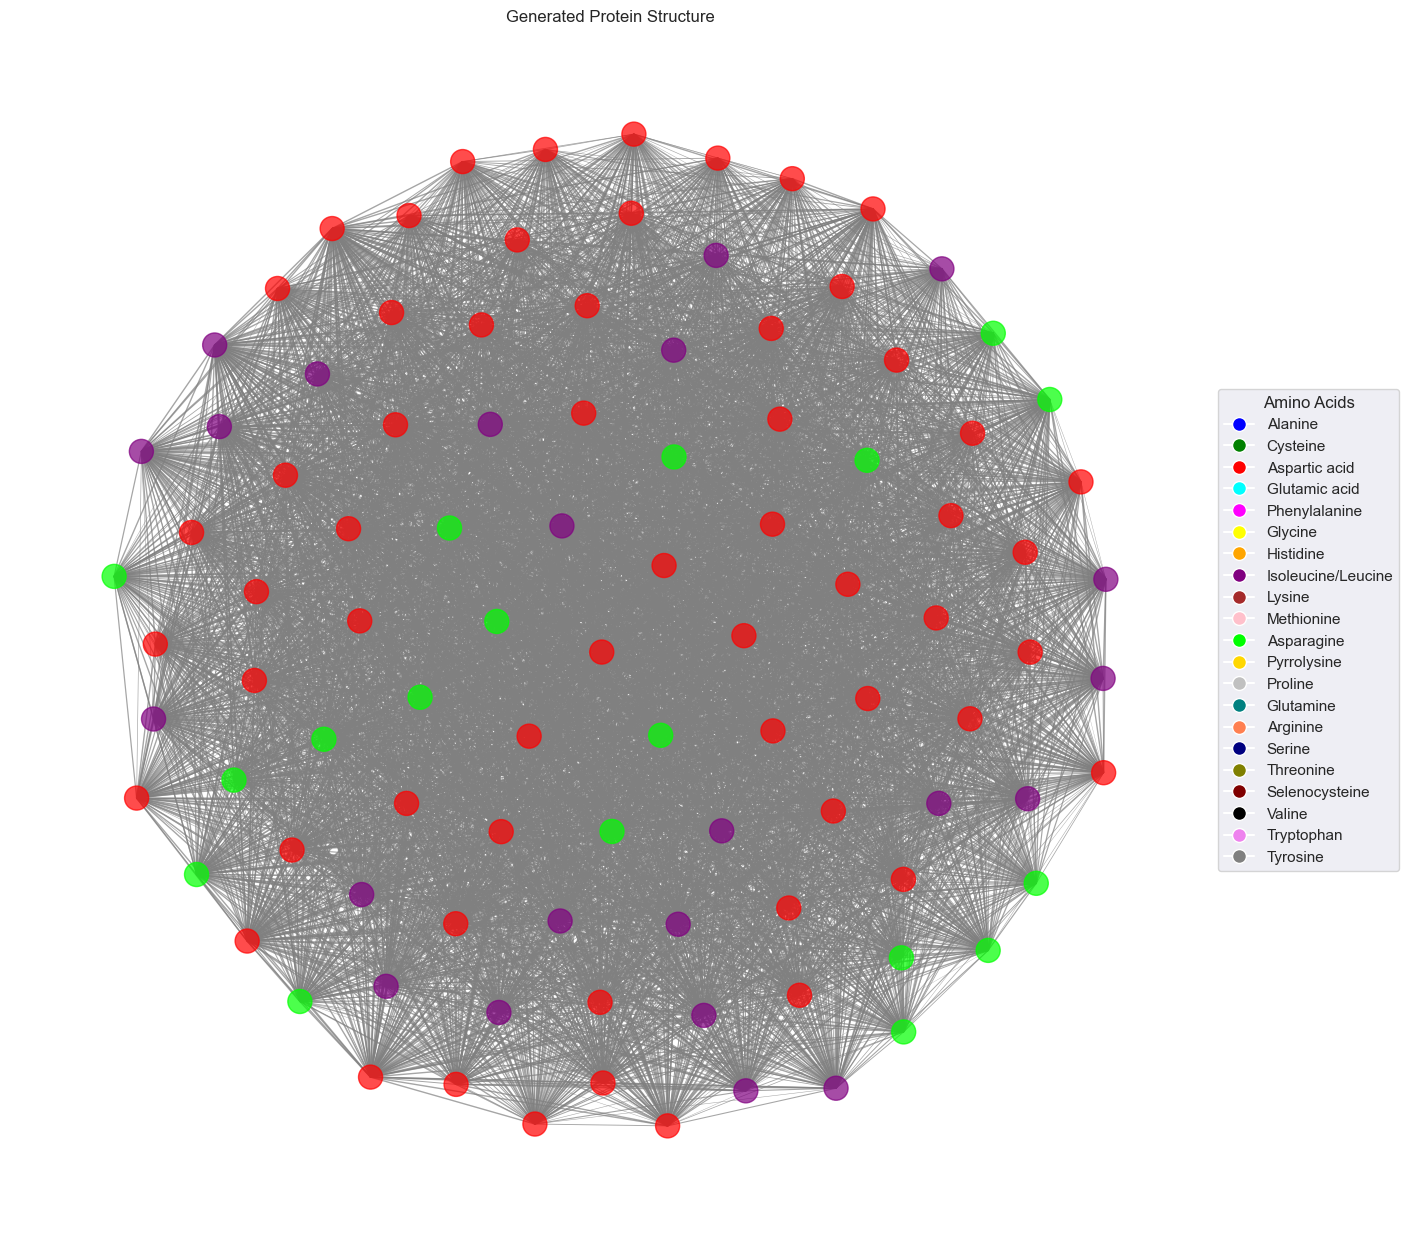

In [161]:
generated_protein = generated_proteins[0]  # Assume you have generated graphs
visualize_generated_protein_graph(generated_protein, title="Generated Protein Structure")


In [162]:
generated_proteins[0]

Data(x=[100, 8], edge_index=[2, 9900], edge_attr=[9900, 1])

In [163]:
generated_proteins[1]

Data(x=[100, 8], edge_index=[2, 9900], edge_attr=[9900, 1])


Graph Info


AttributeError: 'tuple' object has no attribute 'x'

In [164]:
print_graph_info(generated_protein)


Graph Info
Node features shape: torch.Size([100, 8])
Edge index shape: torch.Size([2, 9900])

Feature statistics:
Mass range: 0.00 to 0.00
Avg Neighbor Dist range: 0.00 to 0.00
Max Neighbor Dist range: 0.00 to 0.00
Neighbor Count range: 0.00 to 0.00
Small Molecules ratio: -5.64

Sample nodes:

Node 0:
  Mass: 0.00
  Avg/Max Neighbor Dist: 0.00/0.00
  Neighbor Count: 0
  Small Molecules: -6
  Coordinates: (0.05, -0.13, -0.19)

Node 1:
  Mass: 0.00
  Avg/Max Neighbor Dist: 0.00/0.00
  Neighbor Count: 0
  Small Molecules: -6
  Coordinates: (0.05, -0.12, -0.18)

Node 2:
  Mass: 0.00
  Avg/Max Neighbor Dist: 0.00/0.00
  Neighbor Count: 0
  Small Molecules: -5
  Coordinates: (0.04, -0.13, -0.20)

Node 3:
  Mass: 0.00
  Avg/Max Neighbor Dist: 0.00/0.00
  Neighbor Count: 0
  Small Molecules: -5
  Coordinates: (0.07, -0.11, -0.18)

Node 4:
  Mass: 0.00
  Avg/Max Neighbor Dist: 0.00/0.00
  Neighbor Count: 0
  Small Molecules: -6
  Coordinates: (0.05, -0.12, -0.20)


New generator: 

In [91]:
def generate_protein_graphs(model, norm_params, num_samples=3, nodes_per_graph=100, temperature=1.0):
    """Generate new protein graphs with diverse node features"""
    # Determine device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    feature_means, feature_stds = norm_params  # Unpack normalization parameters
    model.eval()
    model = model.to(device)

    generated_graphs = []

    with torch.no_grad():
        # Sample diverse latent vectors
        z = torch.randn(num_samples, model.latent_channels, device=device) * temperature

        # Add small random noise for variability
        z = z + torch.randn_like(z) * 0.1

        for i in range(num_samples):
            # Expand latent vector for all nodes
            z_expanded = z[i].unsqueeze(0).repeat(nodes_per_graph, 1)

            # Decode latent vectors into node features
            decoded_features, _ = model.decode(z_expanded, nodes_per_graph, edge_index=None)

            # Unnormalize features
            decoded_features = decoded_features * feature_stds.to(device) + feature_means.to(device)

            # Generate edges based on spatial coordinates (decoded)
            coords = decoded_features[:, -3:]  # Extract X, Y, Z
            edge_index, edge_attr = generate_edges_from_coordinates(coords, threshold=5.0)

            # Create PyG Data object
            graph = Data(
                x=decoded_features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            generated_graphs.append(graph)

    return generated_graphs


def generate_edges_from_coordinates(coords, threshold=5.0):
    """Generate edges based on distances between coordinates"""
    edge_index = []
    edge_attr = []

    for i in range(coords.size(0)):
        for j in range(i + 1, coords.size(0)):
            dist = torch.norm(coords[i] - coords[j])
            if dist < threshold:
                edge_index.append([i, j])
                edge_index.append([j, i])
                edge_attr.append([dist.item()])
                edge_attr.append([dist.item()])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return edge_index, edge_attr


In [103]:
generated_proteins = generate_protein_graphs(
    model=model,
    norm_params=(, feature_stds),
    num_samples=3,
    nodes_per_graph=100,
    temperature=1.0
)

# Check if graphs are diverse
for i, graph in enumerate(generated_proteins):
    print(f"Graph {i}: Node Features Mean: {graph.x.mean(dim=0)}, Std: {graph.x.std(dim=0)}")


NameError: name 'feature_means' is not defined